# Imports

In [1]:
import pandas as pd
import numpy as np
import openpyxl
import os
import panel as pn
import seaborn as sns
import matplotlib.pyplot as plt
pn.extension('tabulator')

# import hvplot.pandas

# Configura o Pandas para mostrar numeros sem unidade cientifica, e com até 2 casas decimais
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)

# Ler base Salarios

In [2]:
df = pd.read_csv('base_salarios_completa.csv')

In [3]:
df.shape

(1379124, 20)

# Transformação 1

##### Tratando Colunas

In [4]:
df = df.rename(columns={'Bruto c/ Deduções': 'Bruto recebido'})

In [5]:
# Removendo espaços do Código Cargo
df['Código Cargo'] = (
    df['Código Cargo'].str.replace('\n','')
    .str.rstrip()
    .str.lstrip()    
    .to_list()
)


##### Filtro 1

In [6]:
# Filtra Matriculas válidas
df = df[(df['Matricula']!="true") & (df['Código Cargo']!="")] # Remove a linha true, erro da base
df.shape

(1379032, 20)

##### Tratando Colunas

In [7]:
# Divide o Código cargo em numero e nome
df['Numero Cargo'] = df['Código Cargo'].str.split(' ').str[0] 
df['Numero Cargo'] = df['Numero Cargo'].astype(int)
df['Nome Cargo'] = (
    df['Código Cargo'].str.split(' ')
    .str[2:]
    .str.join(' ')
    .str.replace(' \n', '')
    .str.replace('\n', '')
)

df['Nome Cargo'] = (
    df['Nome Cargo'].str.replace('\n','')
    .str.rstrip()
    .str.lstrip()    
    .to_list()
)

df['Secretaria'] = (
    df['Secretaria'].str.replace('\n','')
    .str.rstrip()
    .str.lstrip()    
    .to_list()
)

df['Nome Lotação'] = (
    df['Nome Lotação'].str.replace('\n','')
    .str.rstrip()
    .str.lstrip()    
    .to_list()
)

# Coluna Ano
df['Ano'] = df['Anomes'].astype(str).str[:4].astype(int)


# Transforma moeda real (R$ 0.000,00) em float das colunas de verbas
colunas_verbas = ['Verbas Fixas', 'Cargo Comissão / Função Gratificada',
       'Produtividade', 'Hora Extra/Adicionais', 'Sucumbência', 'Eventual',
       'Adic.Crg./ Local/Jorn.', 'Salário Atraso', 'Prêmio Férias',
       'Licença Prêmio', '13º Salário', 'Total Bruto', 'Deduções',
       'Bruto recebido']
for item in colunas_verbas:
    if df[item].dtype != float:
        df[item] = (
            df[item]
            .str.replace('\.','')
            .str[3:]
            .str.replace(',','.')
            .astype(float)
        )

# Converte colunas categoricas
category_columns = ['Secretaria', 'Codigo Lotação', 'Código Cargo','Nome Lotação', 'Nome Cargo']
df[category_columns] = df[category_columns].astype('category')

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\74255936.py:47: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace('\.','')


##### Filtro 2

In [8]:
df = df[~((df['Verbas Fixas']==0) | (df['Bruto recebido']==0))]
df.shape

(1161187, 23)

##### Filtro 3

In [9]:
# Filtro de acordo com o salário minimo do ano anterior
df = df[
    (df['Ano']==2016) & (df['Bruto recebido']>=788 ) | 
    (df['Ano']==2017) & (df['Bruto recebido']>=880 ) |
    (df['Ano']==2018) & (df['Bruto recebido']>=937 ) |
    (df['Ano']==2019) & (df['Bruto recebido']>=954 ) |
    (df['Ano']==2020) & (df['Bruto recebido']>=998 ) |
    (df['Ano']==2021) & (df['Bruto recebido']>=1039) |
    (df['Ano']==2022) & (df['Bruto recebido']>=1100) |
    (df['Ano']==2023) & (df['Bruto recebido']>=1212) 
]
df.shape

(1157952, 23)

# Transformação 2 - Join das bases

In [10]:
### Cargos em comissão
cargosemcomissao = pd.read_csv('cargosemcomissao.csv')

cargosemcomissao = cargosemcomissao.rename({'CÓDIGO': 'Numero Cargo'}, axis=1).rename({'SALÁRIO TOTAL': 'Salário Previsto Cargo Comissao'}, axis=1)
del cargosemcomissao['CARGOS']
cargosemcomissao['Numero Cargo'] = cargosemcomissao['Numero Cargo'].astype(int)

### Dados Cargos
dados_cargos = pd.read_csv("dados_cargos.csv").reset_index() # Abre dados cargos
dados_cargos = dados_cargos.drop(dados_cargos.columns[[0, 1]],axis = 1) # removidas a primeira e segunda coluna
dados_cargos = dados_cargos.rename({'codigo_cargo': 'Numero Cargo'}, axis=1)

dados_cargos["Numero Cargo"] = dados_cargos["Numero Cargo"].astype(int)

## join

In [11]:
df1 = pd.merge(df,cargosemcomissao,on='Numero Cargo', how = 'left')
df2 = pd.merge(df1, dados_cargos, "left", "Numero Cargo")

# String na flag_comissao
df2 = df2.fillna(value={'FLAG_COMISSAO':False})
df2['FLAG_COMISSAO'] = np.where(df2['FLAG_COMISSAO'], 'Funcionário Comissionado', 'Funcionário não comissionado')

#Fillna
df2 = df2.fillna("Nulo")

# Novas colunas categoricas
category_columns = ['nome_completo', 'jornada_mensal', 'FLAG_COMISSAO', 'requisitos', 'experiencia', 'grupo', 'lei', 'decreto']
df2[category_columns] = df2[category_columns].astype('category')

df = df2

In [12]:
df.shape

(1157952, 33)

# Transformação 3 - Novas colunas

#### Media movel de 12 meses para verba fixa e bruto recebido

In [13]:
df = df.sort_values(['Matricula', 'Anomes'])
df['Verbas Fixas média 12 meses'] = df.groupby('Matricula')['Verbas Fixas'].rolling(window=12, min_periods=6).mean().reset_index(0, drop=True)
df['Bruto recebido média 12 meses'] = df.groupby('Matricula')['Bruto recebido'].rolling(window=12, min_periods=6).mean().reset_index(0, drop=True)

##### Condição para categorizar todos os requisitos

Com auxilio a lista de requisitos "df['requisitos'].drop_duplicates().to_list()" foram mapeadas todas as palavras chave dos requisitos a fim de agrupar os requisitos

In [14]:
df['Requisitos agrupados'] =    np.where(df['requisitos'].str.contains('fundamental'), 'a. Ensino Fundamental', 
                                np.where(df['requisitos'].str.contains('médio'), 'b. Ensino Médio', 
                                np.where(
                                        (df['requisitos'].str.contains('graduação') | df['requisitos'].str.contains('bacharel') | df['requisitos'].str.contains('bachareal') | df['requisitos'].str.contains('licenciatura')) & df['requisitos'].str.contains('especialização'), 
                                        'c. Graduação e especialização',
                                np.where(
                                        (df['requisitos'].str.contains('graduação') | df['requisitos'].str.contains('bacharel') | df['requisitos'].str.contains('bachareal') | df['requisitos'].str.contains('licenciatura')) & df['requisitos'].str.contains('registro'), 
                                        'd. Graduação e registro',
                                np.where(
                                        (df['requisitos'].str.contains('graduação') | df['requisitos'].str.contains('bacharel') | df['requisitos'].str.contains('bachareal') | df['requisitos'].str.contains('licenciatura')) & df['requisitos'].str.contains('curso'), 
                                        'e. Graduação e curso',
                                np.where(
                                        (df['requisitos'].str.contains('graduação') | df['requisitos'].str.contains('bacharel') | df['requisitos'].str.contains('bachareal') | df['requisitos'].str.contains('licenciatura')), 
                                        'f. Graduação',
                                np.where(df['requisitos'].str.contains('cursando nível superior'), 'g. Cursando nível superior',
                                np.where(df['requisitos'].str.contains('curso de progressão'), 'h. Curso de progressão',
                                np.where((df['requisitos'].str.contains('livre nomeação do prefeito')) | (df['FLAG_COMISSAO']=='Funcionário Comissionado'), 'i. Cargo Comissionado', 
                                np.where((df['experiencia'].str.contains('anos')), 'j. Apenas experiência Requerida', 
                                'z. Sem Requisito'
                                ))))))))))
                                
df['Requisitos agrupados'] = df['Requisitos agrupados'].astype('category')

df['Experiência Requerida'] =   np.where(df['experiencia'].str.contains('\(dez\) anos'), 'a. 10 Anos', 
                                np.where(df['experiencia'].str.contains('\(oito\) anos'), 'b. 8 Anos', 
                                np.where(df['experiencia'].str.contains('\(seis\) anos'), 'c. 6 Anos', 
                                np.where(df['experiencia'].str.contains('5 anos'), 'd. 5 Anos', 
                                np.where(df['experiencia'].str.contains('4 anos'), 'e. 4 Anos', 
                                np.where(df['experiencia'].str.contains('3 anos'), 'f. 3 Anos',
                                'g. Não é exigido experiência'
                                ))))))
df['Experiência Requerida'] = df['Experiência Requerida'].astype('category')

# Cria coluna com faixas de Bruto recebido
df['Faixa bruto'] = (     
    np.where(df['Bruto recebido média 12 meses'].isna() , None,
    np.where(df['Bruto recebido média 12 meses']>30000  , 'm) > 30 mil',
    np.where(df['Bruto recebido média 12 meses']>27500  , 'l) 27,5 - 30',
    np.where(df['Bruto recebido média 12 meses']>25000  , 'k) 25 - 27,5 mil',
    np.where(df['Bruto recebido média 12 meses']>22500  , 'j) 22,5 - 25 mil',
    np.where(df['Bruto recebido média 12 meses']>20000  , 'i) 20 - 22,5 mil',
    np.where(df['Bruto recebido média 12 meses']>17500  , 'h) 17,5 - 20 mil',
    np.where(df['Bruto recebido média 12 meses']>15000  , 'g) 15 - 17,5 mil',
    np.where(df['Bruto recebido média 12 meses']>12500  , 'f) 12,5 - 15 mil',
    np.where(df['Bruto recebido média 12 meses']>10000  , 'e) 10 - 12,5 mil',
    np.where(df['Bruto recebido média 12 meses']>7500   , 'd) 7,5 - 10 mil',
    np.where(df['Bruto recebido média 12 meses']>5000   , 'c) 5 - 7,5 mil',
    np.where(df['Bruto recebido média 12 meses']>2500   , 'b) 2,5 - 5 mil', 'a) <= 2,5 mil',
    )))))))))))))
)

df['Faixa fixa'] = (     
    np.where(df['Verbas Fixas média 12 meses'].isna() , None,
    np.where(df['Verbas Fixas média 12 meses']>30000  , 'm) > 30 mil',
    np.where(df['Verbas Fixas média 12 meses']>27500  , 'l) 27,5 - 30',
    np.where(df['Verbas Fixas média 12 meses']>25000  , 'k) 25 - 27,5 mil',
    np.where(df['Verbas Fixas média 12 meses']>22500  , 'j) 22,5 - 25 mil',
    np.where(df['Verbas Fixas média 12 meses']>20000  , 'i) 20 - 22,5 mil',
    np.where(df['Verbas Fixas média 12 meses']>17500  , 'h) 17,5 - 20 mil',
    np.where(df['Verbas Fixas média 12 meses']>15000  , 'g) 15 - 17,5 mil',
    np.where(df['Verbas Fixas média 12 meses']>12500  , 'f) 12,5 - 15 mil',
    np.where(df['Verbas Fixas média 12 meses']>10000  , 'e) 10 - 12,5 mil',
    np.where(df['Verbas Fixas média 12 meses']>7500   , 'd) 7,5 - 10 mil',
    np.where(df['Verbas Fixas média 12 meses']>5000   , 'c) 5 - 7,5 mil',
    np.where(df['Verbas Fixas média 12 meses']>2500   , 'b) 2,5 - 5 mil', 'a) <= 2,5 mil',
    )))))))))))))
)

df['Secretaria Agrupada'] = np.where(df['Secretaria'] == 'Gestão e Desenvolvimento de Pessoas', 'Administração/Governo', 
                            np.where(df['Secretaria'] == 'Comunicação', 'Administração/Governo', 
                            np.where(df['Secretaria'] == 'Administração', 'Administração/Governo', 
                            np.where(df['Secretaria'] == 'Gabinete do Prefeito', 'Administração/Governo', 
                            np.where(df['Secretaria'] == 'Gabinete do Prefeito/Governo', 'Administração/Governo', 
                            np.where(df['Secretaria'] == 'Gestão e Controle', 'Administração/Governo', 
                            np.where(df['Secretaria'] == 'Finanças', 'Administração/Governo', 
                            np.where(df['Secretaria'] == 'Esportes e Lazer', 'Cultura', 
                            np.where(df['Secretaria'] == 'Cultura e Turismo', 'Cultura', 
                            np.where(df['Secretaria'] == 'Cultura', 'Cultura', 
                            np.where(df['Secretaria'] == 'Verde, Meio Ambiente e Desenvolvimento Sustentável', 'Desenvolvimento', 
                            np.where(df['Secretaria'] == 'Desenvolvimento Econômico, Tecnologia e Informação', 'Desenvolvimento', 
                            np.where(df['Secretaria'] == 'Desenvolvimento Econômico, Social e Turismo', 'Desenvolvimento', 
                            np.where(df['Secretaria'] == 'Planejamento e Urbanismo', 'Desenvolvimento', 
                            np.where(df['Secretaria'] == 'Infraestrutura', 'Desenvolvimento', 
                            np.where(df['Secretaria'] == 'Educação', 'Educação', 
                            np.where(df['Secretaria'] == 'Rede Mário Gatti', 'Saúde', 
                            np.where(df['Secretaria'] == 'Saúde', 'Saúde', 
                            np.where(df['Secretaria'] == 'Hospital Dr Mário Gatti', 'Saúde', 
                            np.where(df['Secretaria'] == 'Transportes', 'Serviços Públicos', 
                            np.where(df['Secretaria'] == 'Serviços Públicos', 'Serviços Públicos', 
                            np.where(df['Secretaria'] == 'Serviços Externos em Geral', 'Serviços Públicos', 
                            np.where(df['Secretaria'] == 'Ouvidoria Geral do Município', 'Serviços Públicos', 
                            np.where(df['Secretaria'] == 'Cooperação nos Assuntos de Segurança Pública', 'Serviços Públicos', 
                            np.where(df['Secretaria'] == 'Justiça', 'Serviços Públicos', 
                            np.where(df['Secretaria'] == 'Trabalho e Renda', 'Social', 
                            np.where(df['Secretaria'] == 'Habitação', 'Social', 
                            np.where(df['Secretaria'] == 'Assist. Social, pessoa com deficiência, Dir. Hum.', 'Social', 
                            np.where(df['Secretaria'] == 'Direitos da Pessoa com Deficiência e Cidadania', 'Social', None
)))))))))))))))))))))))))))))

# View

In [15]:
df[[
    'Matricula',  
    'Verbas Fixas',
    'Bruto recebido', 'Anomes', 'Numero Cargo', 'Nome Cargo', 'Ano',
    'Verbas Fixas média 12 meses',
    'Bruto recebido média 12 meses', 'Requisitos agrupados',
    'Experiência Requerida', 'Faixa bruto', 'Faixa fixa',
    'Secretaria Agrupada'
]].sample(5)

Matricula  Verbas Fixas  Bruto recebido  Anomes  Numero Cargo  \
416862    1187236       2545.39         2819.04  201902         95130   
1047567   1172654       3160.88         3694.71  202207         70001   
349553     278408       4907.10         4907.10  201810         91958   
316571     656453       3190.02         3190.02  201808         95010   
105803     954012       3580.50         4083.23  201707         61011   

                          Nome Cargo   Ano  Verbas Fixas média 12 meses  \
416862          AG.EDUCACAO INFANTIL  2019                      2449.44   
1047567  AGENTE COMUNITARIO DE SAUDE  2022                      2252.10   
349553              GUARDA MUNICIPAL  2018                      4898.28   
316571         AG. APOIO OPERACIONAL  2018                      2963.39   
105803     MONITOR INFANTO JUVENIL I  2017                      3576.96   

         Bruto recebido média 12 meses    Requisitos agrupados  \
416862                         2910.91         b. Ensino Médio   
1047567                        2524.58        z. Sem Requisito   
349553                         5100.54  h. Curso de progressão   
316571                         3291.72   a. Ensino Fundamental   
105803                         3965.97        z. Sem Requisito   

                Experiência Requerida     Faixa bruto      Faixa fixa  \
416862   g. Não é exigido experiência  b) 2,5 - 5 mil   a) <= 2,5 mil   
1047567  g. Não é exigido experiência  b) 2,5 - 5 mil   a) <= 2,5 mil   
349553                      d. 5 Anos  c) 5 - 7,5 mil  b) 2,5 - 5 mil   
316571   g. Não é exigido experiência  b) 2,5 - 5 mil  b) 2,5 - 5 mil   
105803   g. Não é exigido experiência  b) 2,5 - 5 mil  b) 2,5 - 5 mil   

           Secretaria Agrupada  
416862                Educação  
1047567                  Saúde  
349553       Serviços Públicos  
316571   Administração/Governo  
105803                Educação

In [16]:
df.shape

(1157952, 40)

In [17]:
df.describe().shape

(8, 19)

In [18]:
df.columns

Index(['Matricula', 'Secretaria', 'Codigo Lotação', 'Nome Lotação',
       'Código Cargo', 'Verbas Fixas', 'Cargo Comissão / Função Gratificada',
       'Produtividade', 'Hora Extra/Adicionais', 'Sucumbência', 'Eventual',
       'Adic.Crg./ Local/Jorn.', 'Salário Atraso', 'Prêmio Férias',
       'Licença Prêmio', '13º Salário', 'Total Bruto', 'Deduções',
       'Bruto recebido', 'Anomes', 'Numero Cargo', 'Nome Cargo', 'Ano',
       'Salário Previsto Cargo Comissao', 'FLAG_COMISSAO', 'nome_completo',
       'jornada_mensal', 'requisitos', 'experiencia', 'atribuicoes', 'grupo',
       'lei', 'decreto', 'Verbas Fixas média 12 meses',
       'Bruto recebido média 12 meses', 'Requisitos agrupados',
       'Experiência Requerida', 'Faixa bruto', 'Faixa fixa',
       'Secretaria Agrupada'],
      dtype='object')

In [19]:
df[['Matricula','Código Cargo', 'Numero Cargo', 'Nome Cargo','Verbas Fixas','Bruto recebido','Anomes','Ano']].sample(n=5, random_state=1)

Matricula                    Código Cargo  Numero Cargo  \
916150    1362372              94230 - ENFERMEIRO         94230   
508764    1265385       95330 - ASSISTENTE SOCIAL         95330   
327616      72915  70093 - M-MEDICO NEUROCIRURGIA         70093   
1041421   1333682         97011 - PROFESSOR PEB I         97011   
871953     379166       95080 - AG.ADMINISTRATIVO         95080   

                     Nome Cargo  Verbas Fixas  Bruto recebido  Anomes   Ano  
916150               ENFERMEIRO       6378.72         7029.24  202110  2021  
508764        ASSISTENTE SOCIAL       5968.57         5968.57  201908  2019  
327616   M-MEDICO NEUROCIRURGIA       2756.79         5565.70  201808  2018  
1041421         PROFESSOR PEB I       5324.18         9165.19  202207  2022  
871953        AG.ADMINISTRATIVO       5282.12         5282.12  202107  2021

# Analise - Gráficos

## Variaveis Datas para Analise

In [20]:
range_meses_analise = [202203,202302]
mes_para_filtrar_media_movel = 202203

## 1 - Geral

#### 1.1 Distribuição geral por decil: Esta analise visa dar um panorama geral da distribuição salárial de todos os servidores públicos

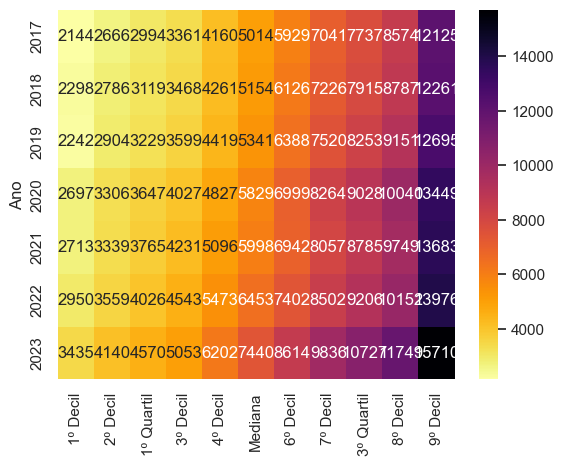

In [21]:
# Cria os Decis do salario Bruto recebido
decil_geral = df[df['Ano']!= 2016].groupby(['Ano']).agg(
    d1 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.1)),
    d2 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.2)),
    q1 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.25)),
    d3 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.3)),
    d4 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.4)),
    d5 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.5)),
    d6 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.6)),
    d7 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.7)),
    q3 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.75)),
    d8 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.8)),
    d9 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.9)),
)

# Renomeia os Decis para melhor interpretabilidade
decil_geral_rn = decil_geral.rename({
    'd1': '1º Decil',
    'd2': '2º Decil',
    'q1': '1º Quartil',
    'd3': '3º Decil',
    'd4': '4º Decil',
    'd5': 'Mediana',
    'd6': '6º Decil',
    'd7': '7º Decil',
    'q3': '3º Quartil',
    'd8': '8º Decil',
    'd9': '9º Decil',
}, axis=1)

# carrega as definições padrões do Seaborn
sns.set()

# define o gráfico
ax = sns.heatmap(decil_geral_rn, annot=True, fmt=".0f", cmap='inferno_r')

# Imprime o Gráfico
plt.show()

#### 1.2 Esta analise visa dar um panorama geral da distribuição salárial de todos os servidores públicos

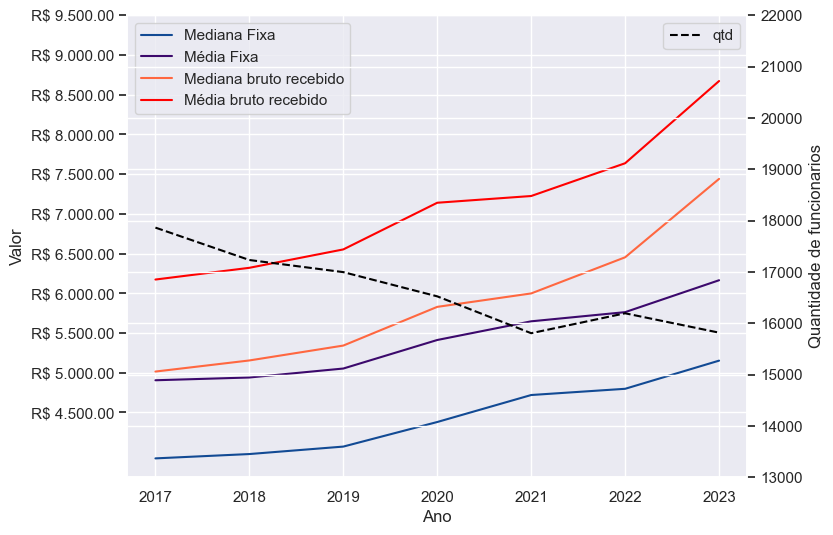

In [22]:
# Ordena os dados por cargo e ano
df1 = df[(df['Ano']!= 2016)]
df1_cargo_ano = df1.groupby(['Ano']).agg(
    mediana_fixa = ('Verbas Fixas média 12 meses', lambda x: x.quantile(0.5)),
    media_fixa = ('Verbas Fixas média 12 meses', 'mean'),
    mediana_bruto = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.5)),
    media_bruto = ('Bruto recebido média 12 meses', 'mean'),
    qtd_pessoas = ('Matricula', 'nunique'),
).reset_index()

sns.set()

fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(data = df1_cargo_ano, x="Ano", y='mediana_fixa', label='Mediana Fixa', color='#124A94')
sns.lineplot(data = df1_cargo_ano, x="Ano", y='media_fixa', label='Média Fixa', color='#3c096c')
sns.lineplot(data = df1_cargo_ano, x="Ano", y='mediana_bruto', label='Mediana bruto recebido', color='#FF6740')
sns.lineplot(data = df1_cargo_ano, x="Ano", y='media_bruto', label='Média bruto recebido', color='red')

ax.set_yticks(range(4500, 10000, 500))

# formatação dos valores do eixo y
plt.gca().yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.'))

ax_aux = ax.twinx()
sns.lineplot(df1_cargo_ano, x="Ano", y='qtd_pessoas', label='qtd', ax=ax_aux, color='black', linestyle="--")
ax_aux.set_yticks(range(13000, 23000, 1000))
ax_aux.set_ylabel('Quantidade de funcionarios')
ax.set_ylabel('Valor')


# Adicionar a legenda à direita dos gráficos
plt.legend()
plt.xticks(rotation=45)

plt.show()

#### 1.3 Esta analise visa dar um panorama geral da distribuição salárial de todos os servidores públicos

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\3813217854.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df1_2_grouped = df1.groupby(['Ano', 'Faixa bruto']).agg({'Matricula': 'nunique'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


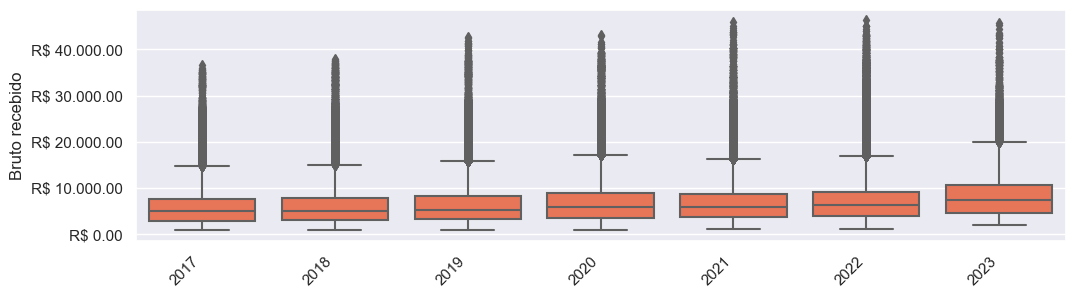

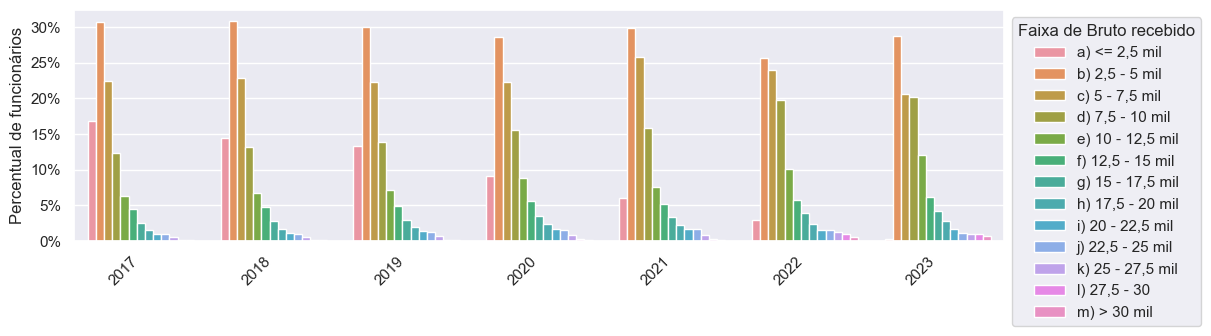

In [23]:
df1 = df

# Cria o boxplot do Bruto recebido
fig, ax1 = plt.subplots(figsize=(12,3))
sns.boxplot(data=df1, x="Ano", y='Bruto recebido média 12 meses', ax=ax1, color='#FF6740')
ax1.set_xlabel('')
ax1.set_ylabel('Bruto recebido')
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_xticklabels(ax1.get_xticklabels(), ha="right")
ax1.yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.'))

# Cria o gráfico de barras da quantidade de servidores por faixa de Bruto recebido
df1_2_grouped = df1.groupby(['Ano', 'Faixa bruto']).agg({'Matricula': 'nunique'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


fig, ax2 = plt.subplots(figsize=(12,3))
sns.barplot(data=df1_2_grouped, x="Ano", y='Matricula', hue='Faixa bruto', ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Percentual de funcionários')
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), ha="right")
ax2.yaxis.set_major_formatter(lambda x, p: f'{int(x):,.0f}%'.replace(',', '.'))
ax2.legend(title='Faixa de Bruto recebido', bbox_to_anchor=(1, 1))

#### 1.4 Massa

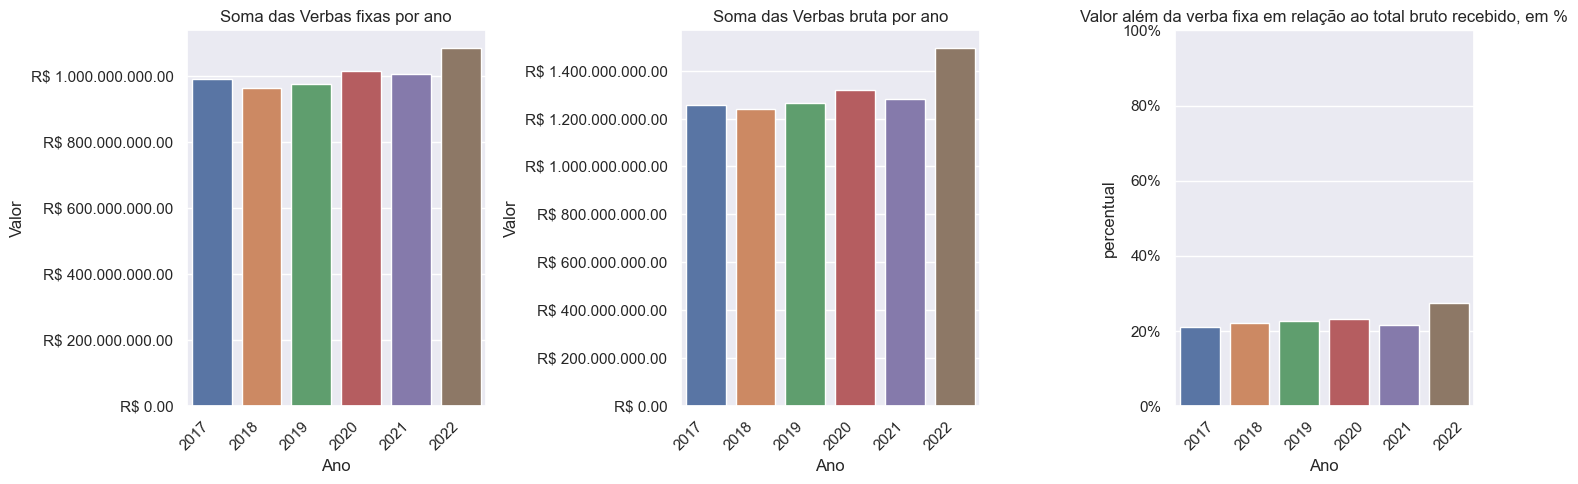

In [24]:
# Ordena os dados por cargo e ano
df1 = df[(df['Ano'] != 2023)]
df1_cargo_ano = df1.groupby(['Ano']).agg(
    verba_fixa = ('Verbas Fixas', 'sum'),
    bruto_recebido = ('Bruto recebido', 'sum'),
    qtd_pessoas = ('Matricula', 'nunique'),
).reset_index()

sns.set()
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

sns.barplot(data = df1_cargo_ano, x="Ano", y='verba_fixa', ax=ax[0])
ax[0].set_title("Soma das Verbas fixas por ano")
ax[0].yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.')) # formatação dos valores do eixo y
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_ylabel('Valor')
# ajuste de alinhamento dos rótulos das barras
labels = ax[0].get_xticklabels() # pega os rótulos do eixo x
ax[0].set_xticklabels(labels, ha="right") # ajusta o alinhamento dos rótulos para a direita

sns.barplot(data = df1_cargo_ano, x="Ano", y='bruto_recebido', ax=ax[1])
ax[1].set_title("Soma das Verbas bruta por ano")
ax[1].yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.')) # formatação dos valores do eixo y
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_ylabel('Valor')
# ajuste de alinhamento dos rótulos das barras
labels = ax[1].get_xticklabels() # pega os rótulos do eixo x
ax[1].set_xticklabels(labels, ha="right") # ajusta o alinhamento dos rótulos para a direita

df1_cargo_ano['percentual'] = 100 * (df1_cargo_ano['bruto_recebido'] - df1_cargo_ano['verba_fixa']) / df1_cargo_ano['bruto_recebido']

sns.barplot(data = df1_cargo_ano, x="Ano", y='percentual', ax=ax[2])
ax[2].set_title("Valor além da verba fixa em relação ao total bruto recebido, em %")
ax[2].yaxis.set_major_formatter(lambda x, p: f'{x:,.0f}%'.replace(',', '.')) # formatação dos valores do eixo y
# ax[2].ticklabel_format(style='plain', axis='y')
ax[2].tick_params(axis='x', labelrotation=45)
ax[2].set_ylim([0, 100])

plt.tight_layout()

#### 1.5 Composição Salarial

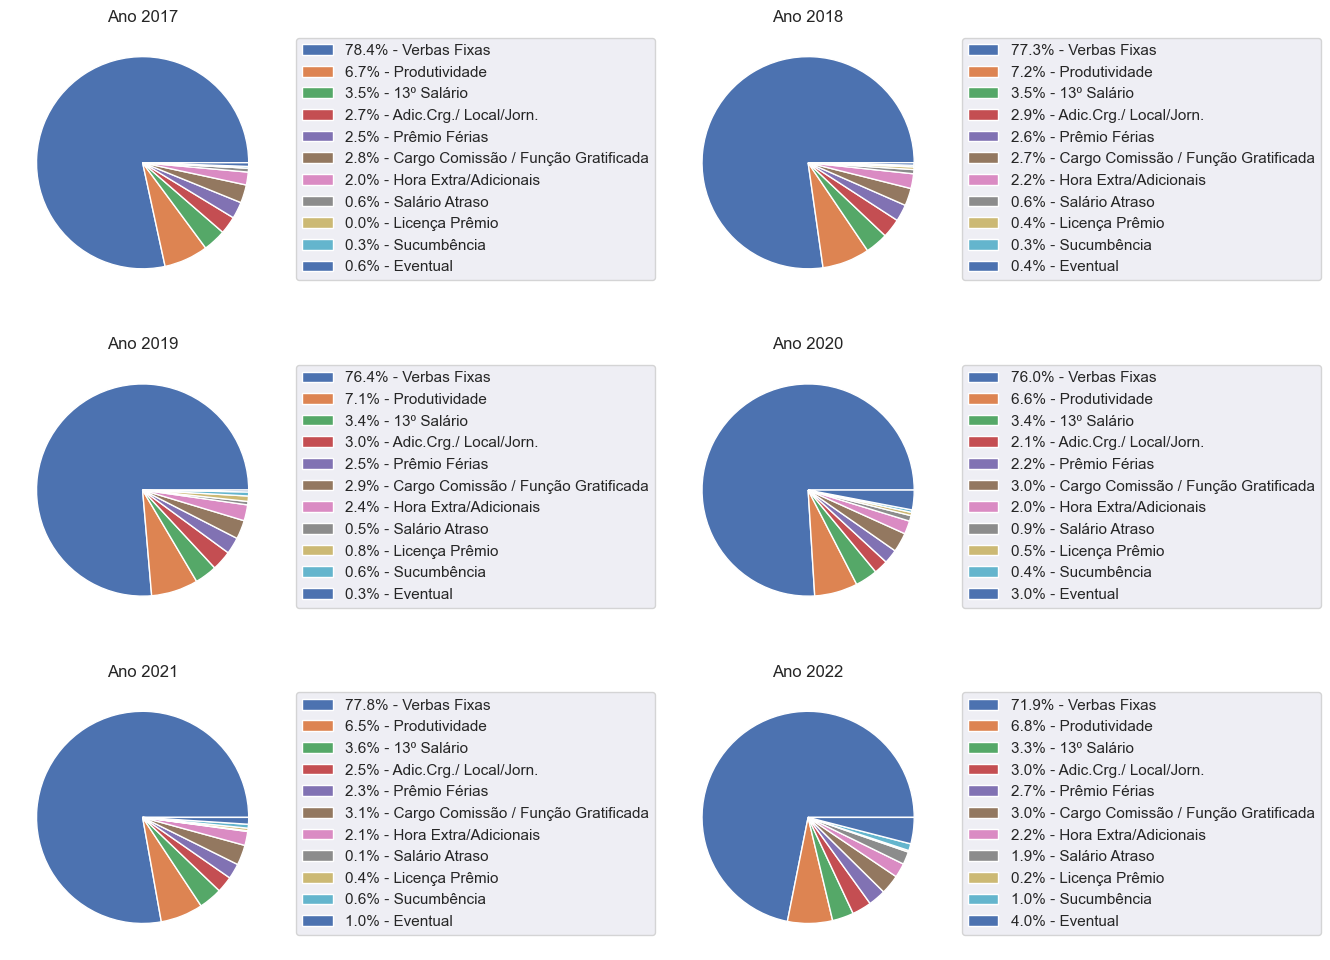

In [25]:
anos = df[df['Ano']!=2023]['Ano'].unique()
verbas = ['Verbas Fixas', 'Produtividade', '13º Salário', 'Adic.Crg./ Local/Jorn.', 'Prêmio Férias', 'Cargo Comissão / Função Gratificada', 'Hora Extra/Adicionais', 'Salário Atraso', 'Licença Prêmio', 'Sucumbência', 'Eventual']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
axs = axs.flatten()

for i, ano in enumerate(anos):
    df_ano = df[df['Ano']==ano][verbas]
    soma = df_ano.sum()
    soma_perc = soma/soma.sum() * 100

    # Obter os índices ordenados pelas porcentagens
    # Criar uma nova lista de rótulos ordenada pelas porcentagens
    labels = [f"{soma_perc[j]:.1f}% - {verbas[j]}" for j, verba in enumerate(verbas)]

    axs[i].pie(soma_perc, labels=None, autopct=None)
    axs[i].legend(labels, bbox_to_anchor=(1.05, 1))
    axs[i].set_title(f'Ano {ano}')

plt.tight_layout()
plt.show()


## 2 - Secretarias
#### Visa descrever o salario mediano por agrupamentos de secretarias

#### 2.1 Decil bruto recebido por secretaria agrupada (mes 202302 media movel)

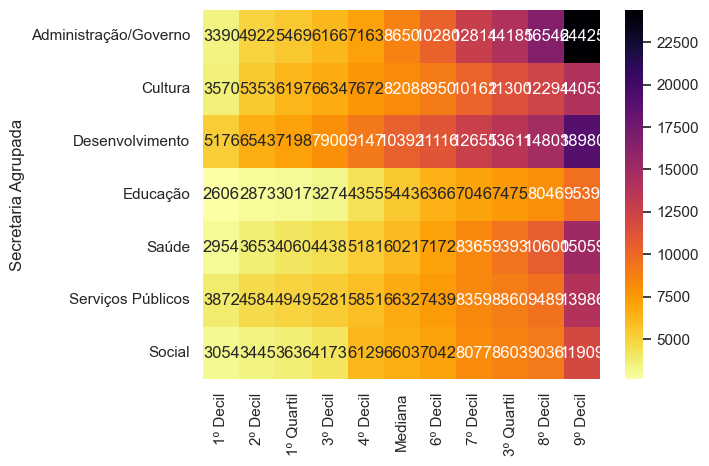

In [26]:
decil_geral = df[df['Anomes']==mes_para_filtrar_media_movel].groupby(['Secretaria Agrupada']).agg(
    d1 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.1)),
    d2 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.2)),
    q1 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.25)),
    d3 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.3)),
    d4 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.4)),
    d5 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.5)),
    d6 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.6)),
    d7 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.7)),
    q3 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.75)),
    d8 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.8)),
    d9 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.9)),
)

# Renomeia os Decis para melhor interpretabilidade
decil_geral_rn = decil_geral.rename({
    'd1': '1º Decil',
    'd2': '2º Decil',
    'q1': '1º Quartil',
    'd3': '3º Decil',
    'd4': '4º Decil',
    'd5': 'Mediana',
    'd6': '6º Decil',
    'd7': '7º Decil',
    'q3': '3º Quartil',
    'd8': '8º Decil',
    'd9': '9º Decil',
}, axis=1)

# carrega as definições padrões do Seaborn
sns.set()

# define o gráfico
ax = sns.heatmap(decil_geral_rn, annot=True, fmt=".0f", cmap="inferno_r")

# Imprime o Gráfico
plt.show()

#### 2.2 Linha media e mediana por tempo por secretaria agrupada (media movel - varios anos)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\925108642.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_mediana_secretaria_agrupada = mediana_secretaria_agrupada.pivot('Ano', 'Secretaria Agrupada', 'mediana')


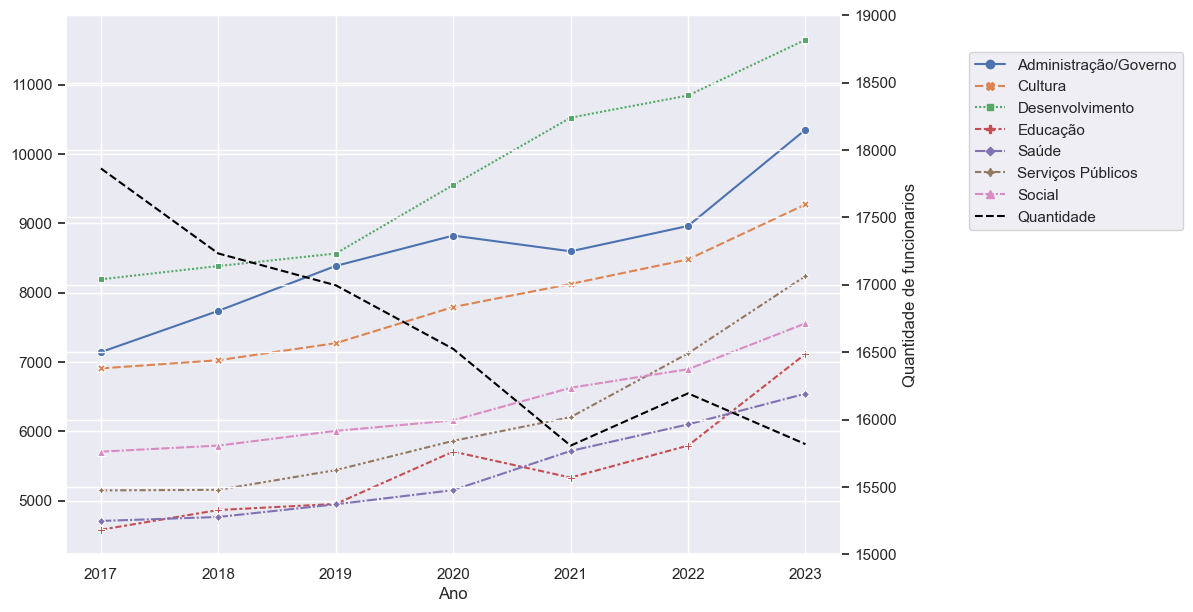

In [27]:
mediana_secretaria_agrupada = df.groupby(['Ano', 'Secretaria Agrupada']).agg(
    mediana = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.5)),
).reset_index() 

pivot_mediana_secretaria_agrupada = mediana_secretaria_agrupada.pivot('Ano', 'Secretaria Agrupada', 'mediana')

sns.set()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.lineplot(pivot_mediana_secretaria_agrupada, markers=True, ax=ax)
ax.legend_.remove() # remove a legenda do interior do gráfico


# Cria eixo secundario com quantidade de pessoas
mediana_quantidade = df.groupby(['Ano']).agg(
    quantidade = ('Matricula', 'nunique')
).reset_index() 

ax_aux = ax.twinx()
sns.lineplot(mediana_quantidade, x="Ano", y='quantidade', label='Quantidade', ax=ax_aux, color='black', linestyle="--")
ax_aux.set_ylim([15e3, 19e3])
ax_aux.set_ylabel('Quantidade de funcionarios')
ax_aux.legend_.remove() # remove a legenda do interior do gráfico

# Cria apenas uma legenda
handles, labels = ax.get_legend_handles_labels()
handles_aux, labels_aux = ax_aux.get_legend_handles_labels()
handles = handles + handles_aux
labels = labels + labels_aux
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.25, 0.7))


plt.show()

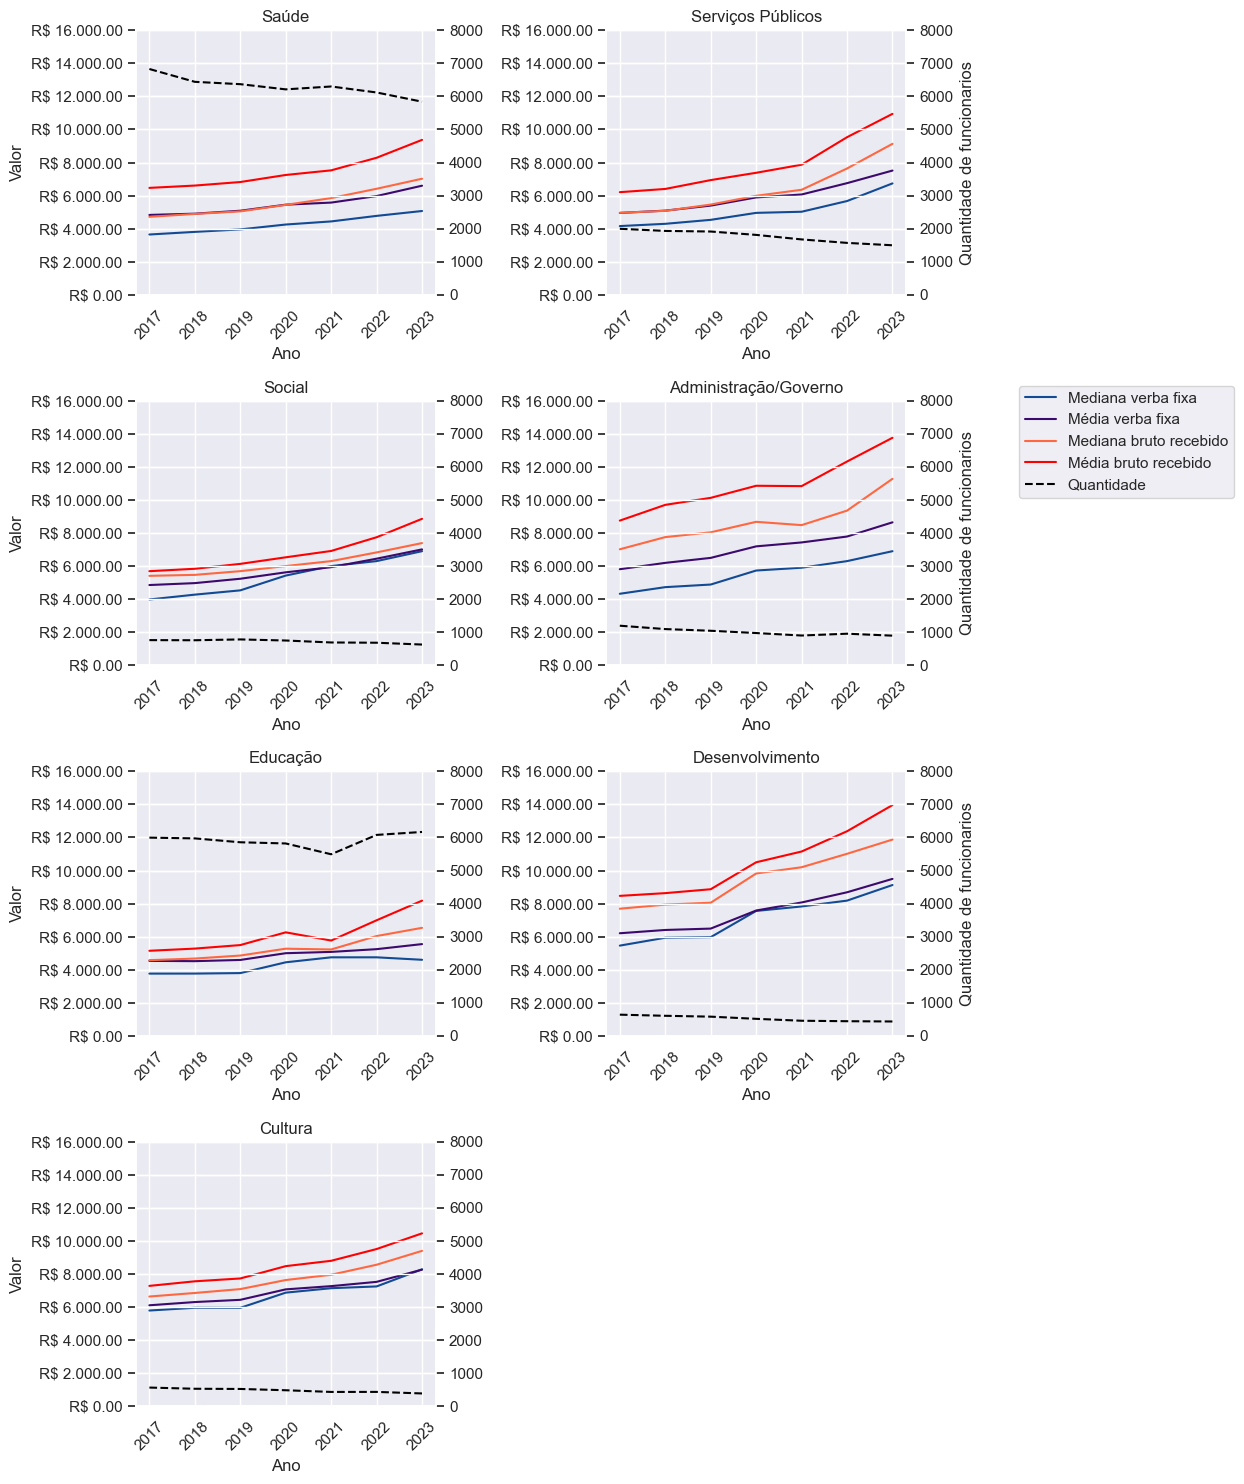

In [28]:
df2 = df[df['Ano']!= 2016]
df2['Secretaria Agrupada'] = df2['Secretaria Agrupada'].astype(str)
df2_cargo_ano = df2.groupby(['Ano', 'Secretaria Agrupada']).agg(
    mediana_fixa = ('Verbas Fixas', lambda x: x.quantile(0.5)),
    media_fixa = ('Verbas Fixas', 'mean'),
    mediana_bruto = ('Bruto recebido', lambda x: x.quantile(0.5)),
    media_bruto = ('Bruto recebido', 'mean'),
    qtd_pessoas = ('Matricula', 'nunique'),
).reset_index()

# Criando a figura com 2 subplots (ax1 e ax2)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
ax = ax.flatten()

cats = ['Saúde', 'Serviços Públicos', 'Social', 'Administração/Governo',
       'Educação', 'Desenvolvimento', 'Cultura']

for i, cat in enumerate(cats):
    df2_1 = df2_cargo_ano[df2_cargo_ano['Secretaria Agrupada'] == cat]
    sns.lineplot(data=df2_1, x="Ano", y='mediana_fixa', label='Mediana verba fixa', ax=ax[i], color='#124A94')
    sns.lineplot(data=df2_1, x="Ano", y='media_fixa', label='Média verba fixa', ax=ax[i], color='#3c096c')
    sns.lineplot(data=df2_1, x="Ano", y='mediana_bruto', label='Mediana bruto recebido', ax=ax[i], color='#FF6740')
    sns.lineplot(data=df2_1, x="Ano", y='media_bruto', label='Média bruto recebido', ax=ax[i], color='red')
    ax[i].set_title(cat)
    ax[i].yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.'))
    ax[i].set_ylabel('Valor' if i%2 == 0 else '')
    ax[i].tick_params(axis='x', labelrotation=45)
    ax[i].set_xticks(df2_1['Ano'].unique())
    ax[i].set_ylim([0, 16000])
    ax[i].legend_.remove() # remove a legenda do interior do gráfico

    # Cria eixo secundario com quantidade de pessoas
    ax_aux = ax[i].twinx()
    sns.lineplot(df2_1, x="Ano", y='qtd_pessoas', label='Quantidade', ax=ax_aux, color='black', linestyle="--")
    ax_aux.set_ylim([0, 8e3])
    ax_aux.set_ylabel('Quantidade de funcionarios' if i%2 == 1 else '')
    ax_aux.legend_.remove() # remove a legenda do interior do gráfico

# Cria apenas uma legenda
handles, labels = ax[0].get_legend_handles_labels()
handles_aux, labels_aux = ax_aux.get_legend_handles_labels()
handles = handles + handles_aux
labels = labels + labels_aux
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.25, 0.7))


ax[7].set_visible(False)
plt.tight_layout()
plt.show()

#### 2.3 Boxplot e quantidade por faixa (202302 media móvel)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\55072463.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df2_2_grouped = df2.groupby(['Secretaria Agrupada', 'Faixa bruto']).agg({'Matricula': 'nunique'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


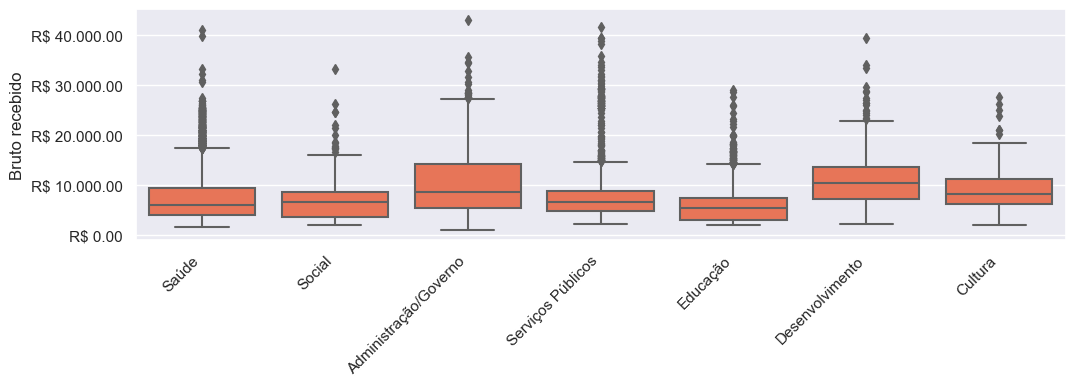

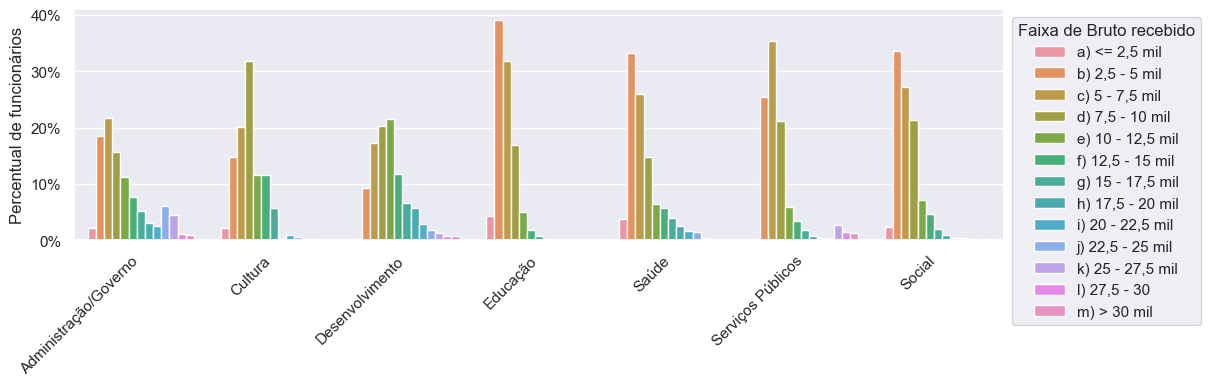

In [29]:
df2 = df[(df['Anomes']==mes_para_filtrar_media_movel)]

# Cria o boxplot do Bruto recebido
fig, ax1 = plt.subplots(figsize=(12,3))
sns.boxplot(data=df2, x="Secretaria Agrupada", y='Bruto recebido média 12 meses', ax=ax1, color='#FF6740')
ax1.set_xlabel('')
ax1.set_ylabel('Bruto recebido')
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_xticklabels(ax1.get_xticklabels(), ha="right")
ax1.yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.'))


# Cria o gráfico de barras da quantidade de servidores por faixa de Bruto recebido
df2_2_grouped = df2.groupby(['Secretaria Agrupada', 'Faixa bruto']).agg({'Matricula': 'nunique'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
fig, ax2 = plt.subplots(figsize=(12,3))
sns.barplot(data=df2_2_grouped, x="Secretaria Agrupada", y='Matricula', hue='Faixa bruto', ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Percentual de funcionários')
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), ha="right")
ax2.yaxis.set_major_formatter(lambda x, p: f'{int(x):,.0f}%'.replace(',', '.'))
ax2.legend(title='Faixa de Bruto recebido', bbox_to_anchor=(1, 1))

#### 2.4 Massa e percentual extra (media móvel varios anos)

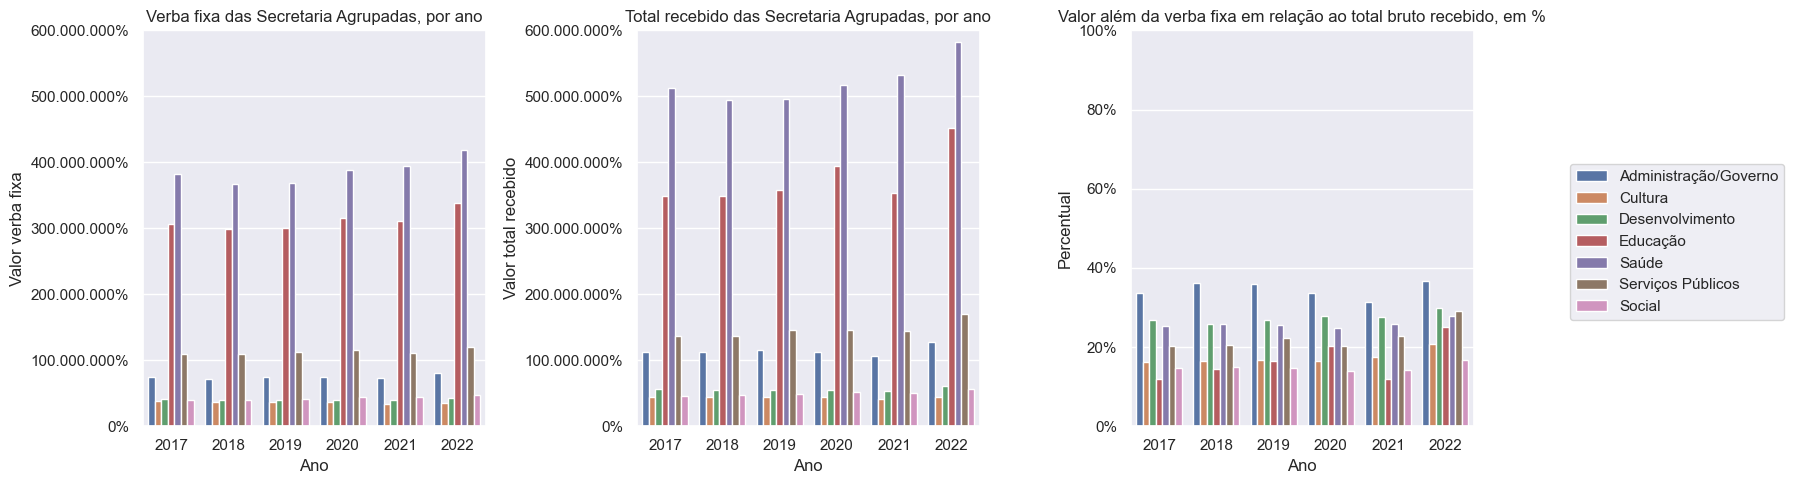

In [30]:
df4 = df[(df['Ano']!= 2016) & (df['Ano']!= 2023) & (df['Bruto recebido'] > 100)] .sort_values(['Nome Cargo', 'Ano'])
df4['total_recebido'] = df4['Bruto recebido']
df4_cargo_ano = df4.groupby(['Secretaria Agrupada', 'Ano']).agg(
    verba_fixa = ('Verbas Fixas', 'sum'),
    total_recebido = ('total_recebido', 'sum'),
    qtd_pessoas = ('total_recebido', 'count'),
).reset_index()


df4_cargo_ano['extra_verba_fixa'] = df4_cargo_ano['total_recebido'] - df4_cargo_ano['verba_fixa']
df4_cargo_ano['percentual'] = 100 * df4_cargo_ano['extra_verba_fixa'] / df4_cargo_ano['total_recebido']


sns.set()

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
axs.flatten()
plt.subplots_adjust(wspace=0.4)

sns.set(rc={'figure.figsize':(12,8)})

sns.barplot(data = df4_cargo_ano, x="Ano", y='verba_fixa', hue='Secretaria Agrupada', ax=axs[0])
axs[0].set_title("Verba fixa das Secretaria Agrupadas, por ano")
axs[0].ticklabel_format(style='plain', axis='y')
axs[0].set_ylabel('Valor verba fixa')
axs[0].set_ylim([0, 6e8])
axs[0].yaxis.set_major_formatter(lambda x, p: f'{x:,.0f}%'.replace(',', '.')) # formatação dos valores do eixo y

sns.barplot(data = df4_cargo_ano, x="Ano", y='total_recebido', hue='Secretaria Agrupada', ax=axs[1])
axs[1].set_title("Total recebido das Secretaria Agrupadas, por ano")
axs[1].ticklabel_format(style='plain', axis='y')
axs[1].set_ylabel('Valor total recebido')
axs[1].set_ylim([0, 6e8])
axs[1].yaxis.set_major_formatter(lambda x, p: f'{x:,.0f}%'.replace(',', '.')) # formatação dos valores do eixo y

sns.barplot(data = df4_cargo_ano, x="Ano", y='percentual', hue='Secretaria Agrupada', ax=axs[2])
axs[2].set_title("Valor além da verba fixa em relação ao total bruto recebido, em %")
axs[2].ticklabel_format(style='plain', axis='y')
axs[2].set_ylabel('Percentual')
axs[2].yaxis.set_major_formatter(lambda x, p: f'{x:,.0f}%'.replace(',', '.')) # formatação dos valores do eixo y
axs[2].set_ylim([0, 100])

# Remover as legendas dos gráficos
axs[0].legend_.remove()
axs[1].legend_.remove()
axs[2].legend_.remove()

# Cria a legenda apenas para o primeiro gráfico
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.show()

#### 2.5 percentual de composição salarial em 12 meses (soma percentual no intervalo: 202203 - 202302)

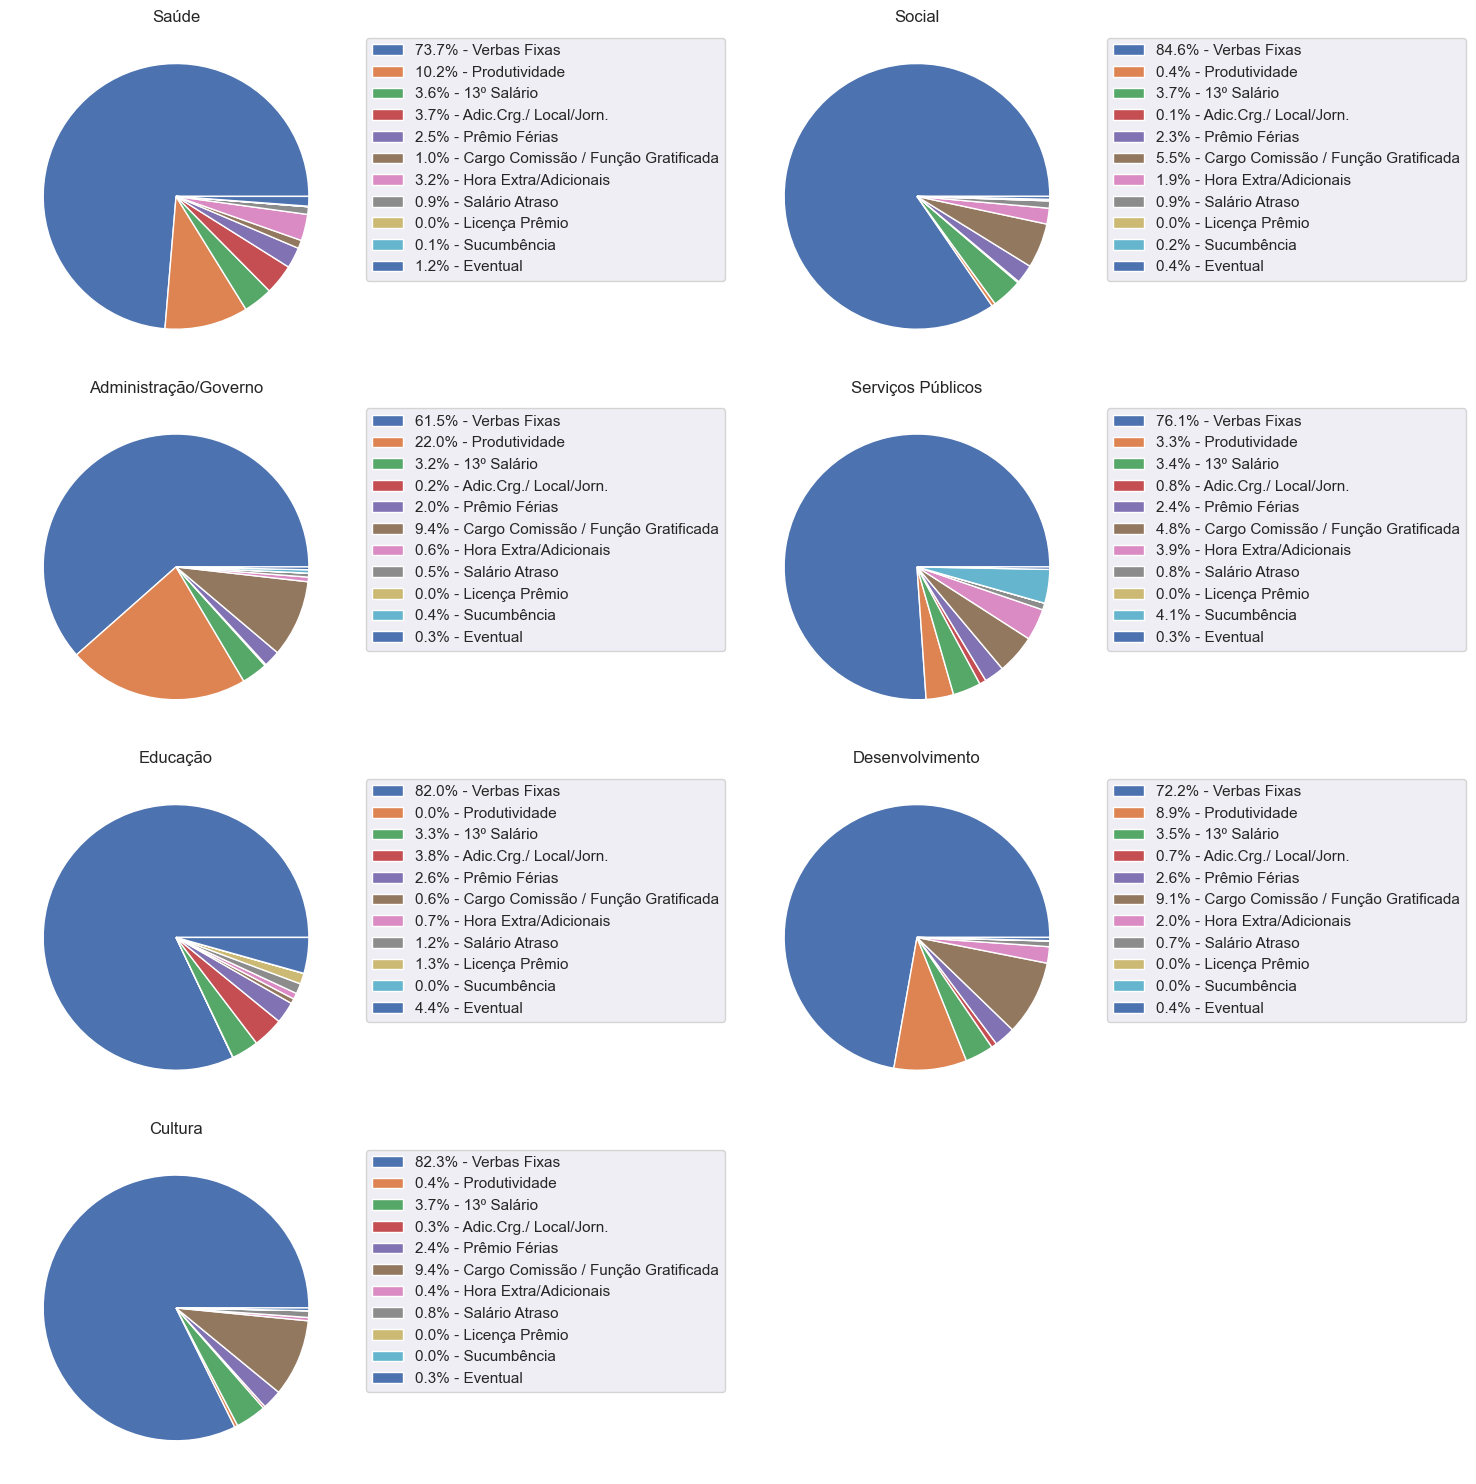

In [33]:
secretaria_agrupada = df[df['Anomes'].between(*range_meses_analise)]['Secretaria Agrupada'].unique()
verbas = ['Verbas Fixas', 'Produtividade', '13º Salário', 'Adic.Crg./ Local/Jorn.', 'Prêmio Férias', 'Cargo Comissão / Função Gratificada', 'Hora Extra/Adicionais', 'Salário Atraso', 'Licença Prêmio', 'Sucumbência', 'Eventual']

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,15))
axs = axs.flatten()

for i, secretaria_agrupada in enumerate(secretaria_agrupada):
    df_ano = df[df['Secretaria Agrupada']==secretaria_agrupada][verbas]
    soma = df_ano.sum()
    soma_perc = soma/soma.sum() * 100

    # Criar uma nova lista de rótulos ordenada pelas porcentagens
    labels = [f"{soma_perc[j]:.1f}% - {verbas[j]}" for j, verba in enumerate(verbas)]

    axs[i].pie(soma_perc, labels=None, autopct=None)
    axs[i].legend(labels, bbox_to_anchor=(1.05, 1))
    axs[i].set_title(f'{secretaria_agrupada}')

axs[7].set_visible(False)
plt.tight_layout()
plt.show()


## 3 - Nivel de requisito (graduação, pos, ...)

### 3.1 Decil de Salário por requisito

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\1029642352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:]


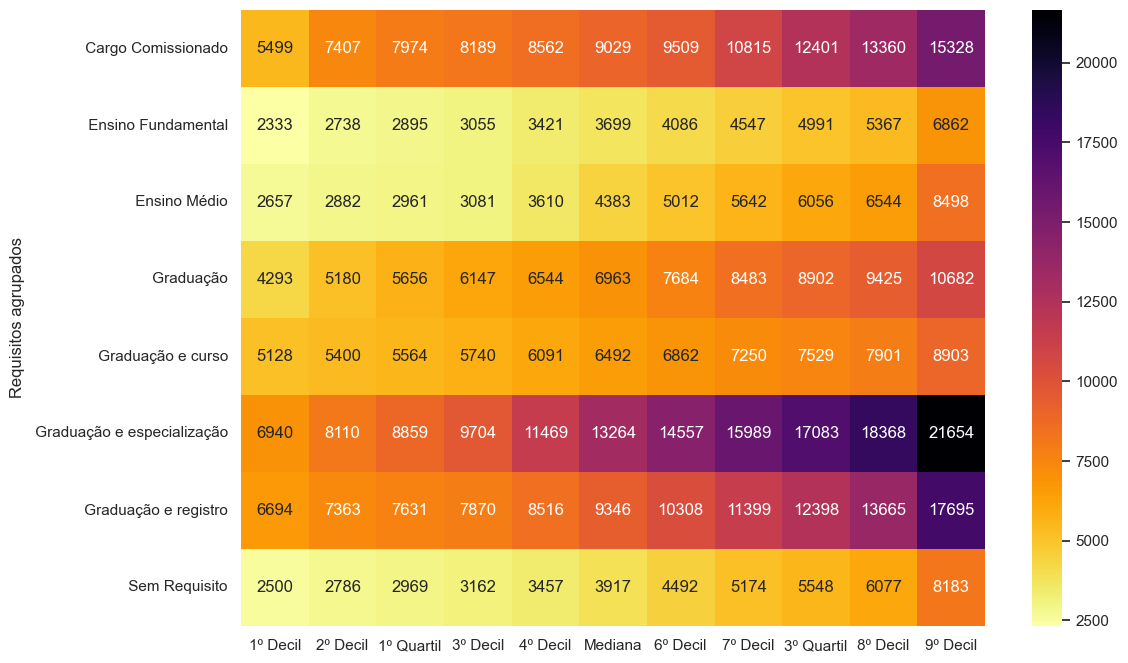

In [34]:
dfaux = df[(df['Anomes']== mes_para_filtrar_media_movel) & (df['Experiência Requerida'].str.contains('Não é exigido experiência'))]
dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:]
decil_geral = (
    dfaux
    .groupby(['Requisitos agrupados']).agg(
    d1 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.1)),
    d2 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.2)),
    q1 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.25)),
    d3 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.3)),
    d4 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.4)),
    d5 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.5)),
    d6 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.6)),
    d7 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.7)),
    q3 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.75)),
    d8 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.8)),
    d9 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.9)),
    )
)

# Renomeia os Decis para melhor interpretabilidade
decil_geral_rn = decil_geral.rename({
    'd1': '1º Decil',
    'd2': '2º Decil',
    'q1': '1º Quartil',
    'd3': '3º Decil',
    'd4': '4º Decil',
    'd5': 'Mediana',
    'd6': '6º Decil',
    'd7': '7º Decil',
    'q3': '3º Quartil',
    'd8': '8º Decil',
    'd9': '9º Decil',
}, axis=1) 

# carrega as definições padrões do Seaborn
sns.set()

# define o gráfico
ax = sns.heatmap(decil_geral_rn, annot=True, fmt=".0f", cmap='inferno_r')

# Imprime o Gráfico
plt.show()

### 3.2 Serie temporal verbas por requisitos

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\1270713847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\1270713847.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_mediana = mediana.pivot('Ano', 'Requisitos agrupados', 'mediana')


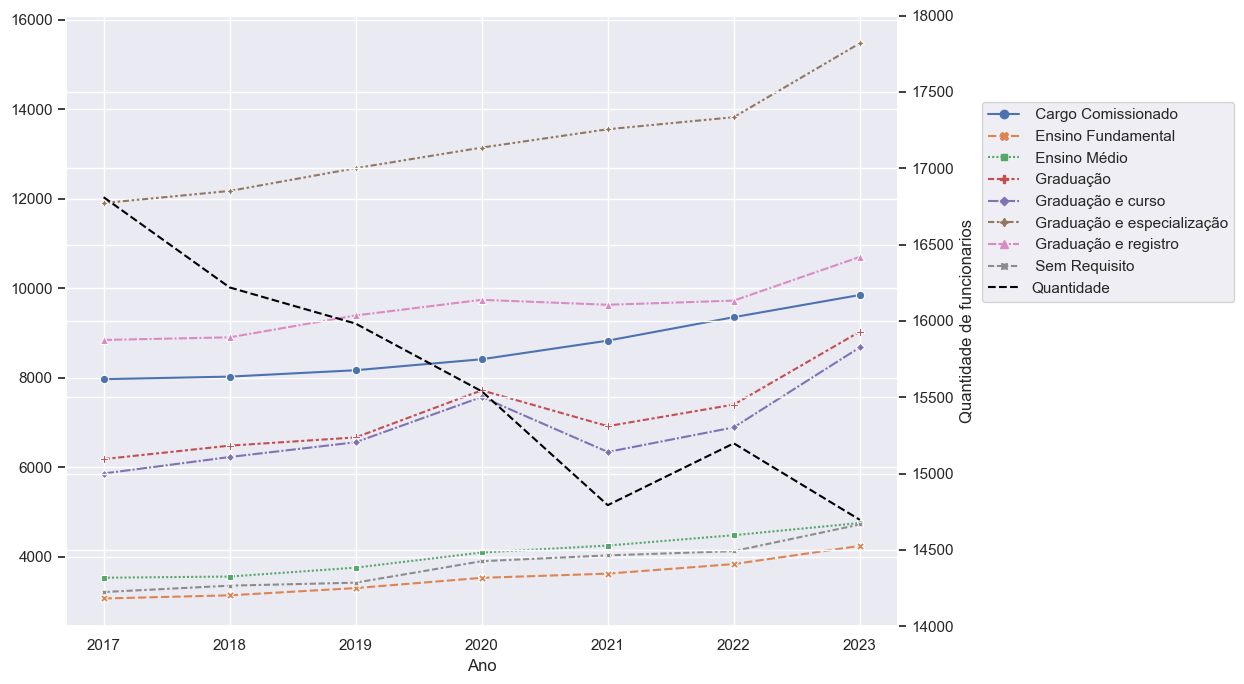

In [35]:
dfaux = df[(df['Ano']!=2016) & (df['Experiência Requerida'].str.contains('Não é exigido experiência'))]
dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:]

mediana = dfaux.groupby(['Ano', 'Requisitos agrupados']).agg(
    mediana = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.5)),
).reset_index() 

pivot_mediana = mediana.pivot('Ano', 'Requisitos agrupados', 'mediana')

sns.set()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))

sns.lineplot(pivot_mediana, markers=True, ax=ax)

ax.legend_.remove() # remove a legenda do interior do gráfico

# Cria eixo secundario com quantidade de pessoas
mediana_quantidade = dfaux.groupby(['Ano']).agg(
    quantidade = ('Matricula', 'nunique')
).reset_index() 

ax_aux = ax.twinx()
sns.lineplot(mediana_quantidade, x="Ano", y='quantidade', label='Quantidade', ax=ax_aux, color='black', linestyle="--")
ax_aux.set_ylim([14e3, 18e3])
ax_aux.set_ylabel('Quantidade de funcionarios')
ax_aux.legend_.remove() # remove a legenda do interior do gráfico

# Cria apenas uma legenda
handles, labels = ax.get_legend_handles_labels()
handles_aux, labels_aux = ax_aux.get_legend_handles_labels()
handles = handles + handles_aux
labels = labels + labels_aux
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.25, 0.7))

plt.tight_layout()
plt.show()

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\2130511196.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str)


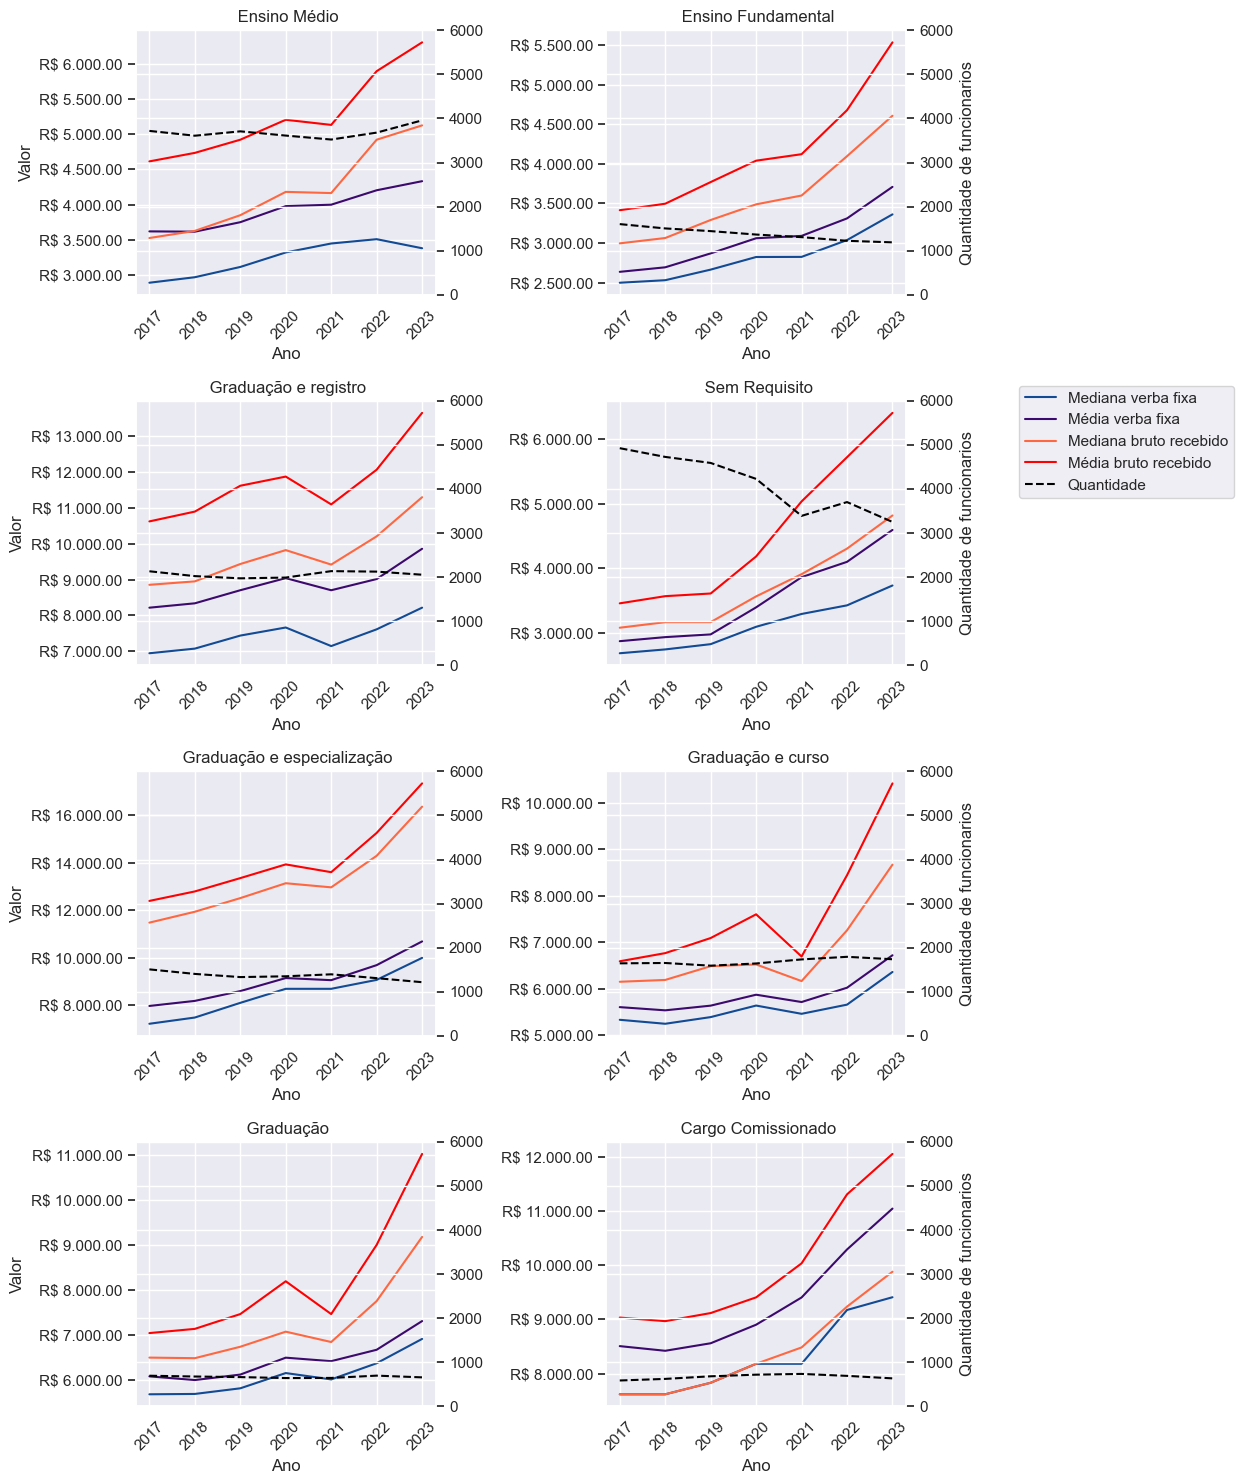

In [36]:
dfaux = df[(df['Ano']!=2016) & (df['Experiência Requerida'].str.contains('Não é exigido experiência'))] # filtra o publico da analise

dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str)
dfaux_cargo_ano = dfaux.groupby(['Requisitos agrupados', 'Ano']).agg(
    mediana_fixa = ('Verbas Fixas', lambda x: x.quantile(0.5)),
    media_fixa = ('Verbas Fixas', 'mean'),
    mediana_bruto = ('Bruto recebido', lambda x: x.quantile(0.5)),
    media_bruto = ('Bruto recebido', 'mean'),
    qtd_pessoas = ('Matricula', 'nunique'),
).reset_index()

# Criando a figura com 2 subplots (ax1 e ax2)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
ax = ax.flatten()

cats = dfaux['Requisitos agrupados'].unique()

for i, cat in enumerate(cats):
    dfaux_1 = dfaux_cargo_ano[dfaux_cargo_ano['Requisitos agrupados'] == cat]
    sns.lineplot(data=dfaux_1, x="Ano", y='mediana_fixa', label='Mediana verba fixa', ax=ax[i], color='#124A94')
    sns.lineplot(data=dfaux_1, x="Ano", y='media_fixa', label='Média verba fixa', ax=ax[i], color='#3c096c')
    sns.lineplot(data=dfaux_1, x="Ano", y='mediana_bruto', label='Mediana bruto recebido', ax=ax[i], color='#FF6740')
    sns.lineplot(data=dfaux_1, x="Ano", y='media_bruto', label='Média bruto recebido', ax=ax[i], color='red')
    ax[i].set_title(cat[2:])
    ax[i].yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.'))
    ax[i].set_ylabel('Valor' if i%2 == 0 else '')
    ax[i].tick_params(axis='x', labelrotation=45)
    ax[i].set_xticks(dfaux_1['Ano'].unique())
    ax[i].legend_.remove() # remove a legenda do interior do gráfico

    # Cria eixo secundario com quantidade de pessoas
    ax_aux = ax[i].twinx()
    sns.lineplot(dfaux_1, x="Ano", y='qtd_pessoas', label='Quantidade', ax=ax_aux, color='black', linestyle="--")
    ax_aux.set_ylim([0, 6e3])
    ax_aux.set_ylabel('Quantidade de funcionarios' if i%2 == 1 else '')
    ax_aux.legend_.remove() # remove a legenda do interior do gráfico

# Cria apenas uma legenda
handles, labels = ax[0].get_legend_handles_labels()
handles_aux, labels_aux = ax_aux.get_legend_handles_labels()
handles = handles + handles_aux
labels = labels + labels_aux
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.25, 0.7))

plt.tight_layout()
plt.show()

### 3.3 Boxplot

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\2433059483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"
C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\2433059483.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:]
C:\Users\Lucas\AppData\Local\Temp\ipykernel

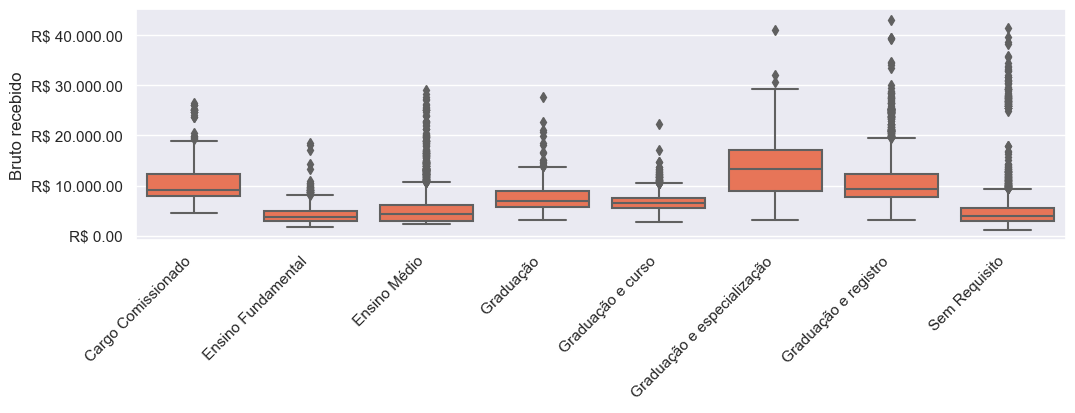

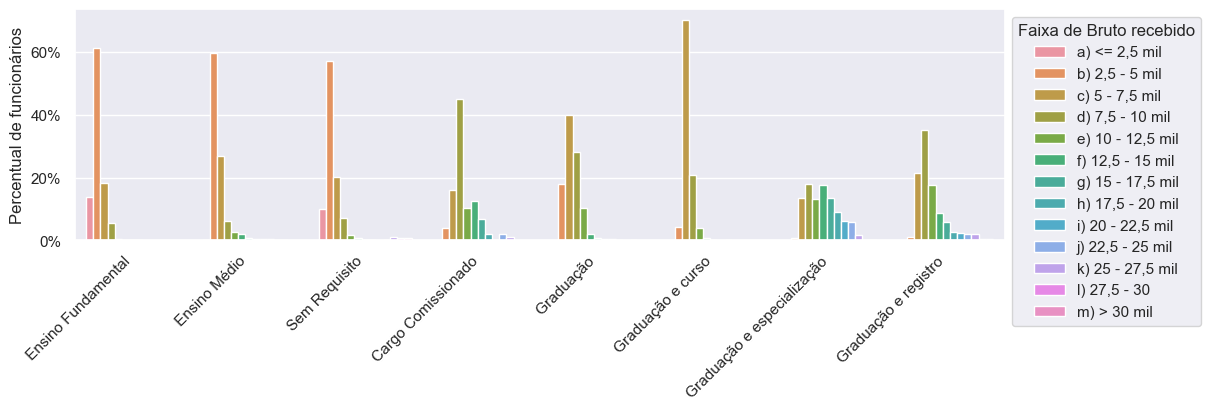

In [37]:
dfaux = df[(df['Anomes']==mes_para_filtrar_media_movel) & ~(df['Experiência Requerida'].str.contains('Não é exigido experiência'))]
dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"
dfaux_cargo_ano = dfaux.groupby(['Requisitos agrupados', 'Ano']).agg(
    mediana_fixa = ('Verbas Fixas média 12 meses', lambda x: x.quantile(0.5)),
    media_fixa = ('Verbas Fixas média 12 meses', 'mean'),
    mediana_bruto = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.5)),
    media_bruto = ('Bruto recebido média 12 meses', 'mean'),
    qtd_pessoas = ('Matricula', 'nunique'),
).reset_index().sort_values('Requisitos agrupados')

dfaux = df[(df['Anomes']==202203) & (df['Experiência Requerida'].str.contains('Não é exigido experiência'))]

dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:]
dfaux = dfaux.sort_values(['Requisitos agrupados', 'Faixa bruto'])

# Cria o boxplot do Bruto recebido
fig, ax1 = plt.subplots(figsize=(12,3))
sns.boxplot(data=dfaux, x="Requisitos agrupados", y='Bruto recebido média 12 meses', ax=ax1, color='#FF6740')
# ax1.set_title('Bruto recebido por categoria de Requisitos agrupados')
ax1.set_xlabel('')
ax1.set_ylabel('Bruto recebido')
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_xticklabels(ax1.get_xticklabels(), ha="right")
ax1.yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.'))

# Cria o gráfico de barras da quantidade de servidores por faixa de Bruto recebido
dfaux_2_grouped = dfaux.groupby(['Requisitos agrupados', 'Faixa bruto']).agg({'Matricula': 'nunique'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index().sort_values(['Faixa bruto','Requisitos agrupados'])
fig, ax2 = plt.subplots(figsize=(12,3))
sns.barplot(data=dfaux_2_grouped, x="Requisitos agrupados", y='Matricula', hue='Faixa bruto', ax=ax2)
# ax2.set_title('Percentual de funcionários por faixa de Bruto recebido')
ax2.set_xlabel('')
ax2.set_ylabel('Percentual de funcionários')
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), ha="right")
ax2.yaxis.set_major_formatter(lambda x, p: f'{int(x):,.0f}%'.replace(',', '.'))
ax2.legend(title='Faixa de Bruto recebido', bbox_to_anchor=(1, 1))

### 3.4 Valores por nível requerido

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\1936284197.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:]


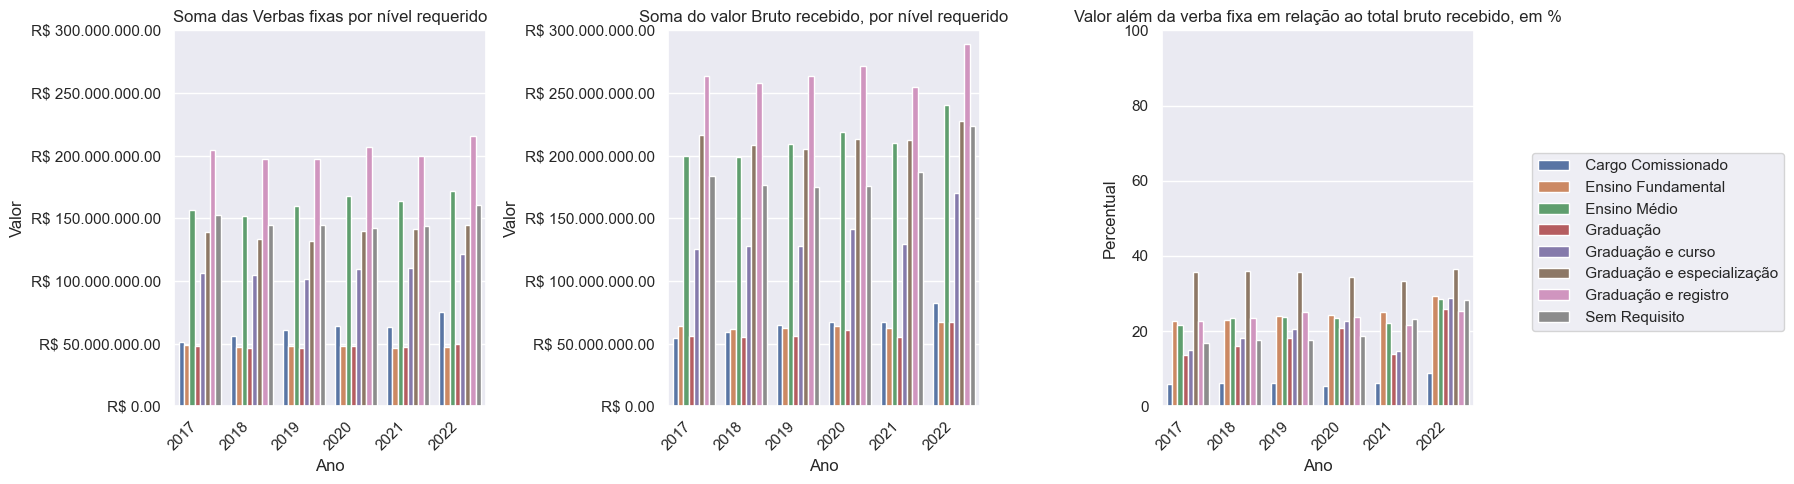

In [38]:
# Ordena os dados por cargo e ano
dfaux = df[(df['Ano']!= 2016) & (df['Ano']!= 2023) & (df['Experiência Requerida'].str.contains('Não é exigido experiência'))]
dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:]
dfaux_cargo_ano = dfaux.groupby(['Ano','Requisitos agrupados']).agg(
    verba_fixa = ('Verbas Fixas', 'sum'),
    bruto_recebido = ('Bruto recebido', 'sum'),
    qtd_pessoas = ('Matricula', 'nunique'),
).reset_index()


dfaux_cargo_ano['percentual'] = 100 * (dfaux_cargo_ano['bruto_recebido'] - dfaux_cargo_ano['verba_fixa']) / dfaux_cargo_ano['bruto_recebido']


sns.set()
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))

sns.barplot(data = dfaux_cargo_ano, x='Ano', y='verba_fixa', hue="Requisitos agrupados", ax=ax[0])
ax[0].set_title("Soma das Verbas fixas por nível requerido")
ax[0].yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.')) # formatação dos valores do eixo y
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_ylabel('Valor')
# ajuste de alinhamento dos rótulos das barras
labels = ax[0].get_xticklabels() # pega os rótulos do eixo x
ax[0].set_xticklabels(labels, ha="right") # ajusta o alinhamento dos rótulos para a direita
ax[0].set_ylim([0, 3e8])

sns.barplot(data = dfaux_cargo_ano, x='Ano', y='bruto_recebido', hue="Requisitos agrupados", ax=ax[1])
ax[1].set_title("Soma do valor Bruto recebido, por nível requerido")
ax[1].yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.')) # formatação dos valores do eixo y
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_ylabel('Valor')
# ajuste de alinhamento dos rótulos das barras
labels = ax[1].get_xticklabels() # pega os rótulos do eixo x
ax[1].set_xticklabels(labels, ha="right") # ajusta o alinhamento dos rótulos para a direita
ax[1].set_ylim([0, 3e8])

sns.barplot(data = dfaux_cargo_ano, x='Ano', y='percentual', hue="Requisitos agrupados", ax=ax[2])
ax[2].set_title("Valor além da verba fixa em relação ao total bruto recebido, em %")
ax[2].yaxis.set_major_formatter(lambda x, p: f'{x:,.0f}'.replace(',', '.')) # formatação dos valores do eixo y
ax[2].tick_params(axis='x', labelrotation=45)
ax[2].set_ylabel('Percentual')
ax[2].set_ylim([0,100])
axs[2].yaxis.set_major_formatter(lambda x, p: f'{x:,.0f}%'.replace(',', '.')) # formatação dos valores do eixo y
# ajuste de alinhamento dos rótulos das barras
labels = ax[2].get_xticklabels() # pega os rótulos do eixo x
ax[2].set_xticklabels(labels, ha="right") # ajusta o alinhamento dos rótulos para a direita

# Remover as legendas dos gráficos
ax[0].legend_.remove()
ax[1].legend_.remove()
ax[2].legend_.remove()

# Cria a legenda apenas para o primeiro gráfico
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout() # Previne sobreposição
plt.show()

### 3.5 Composição Salarial por requisito

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\1251068475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:]


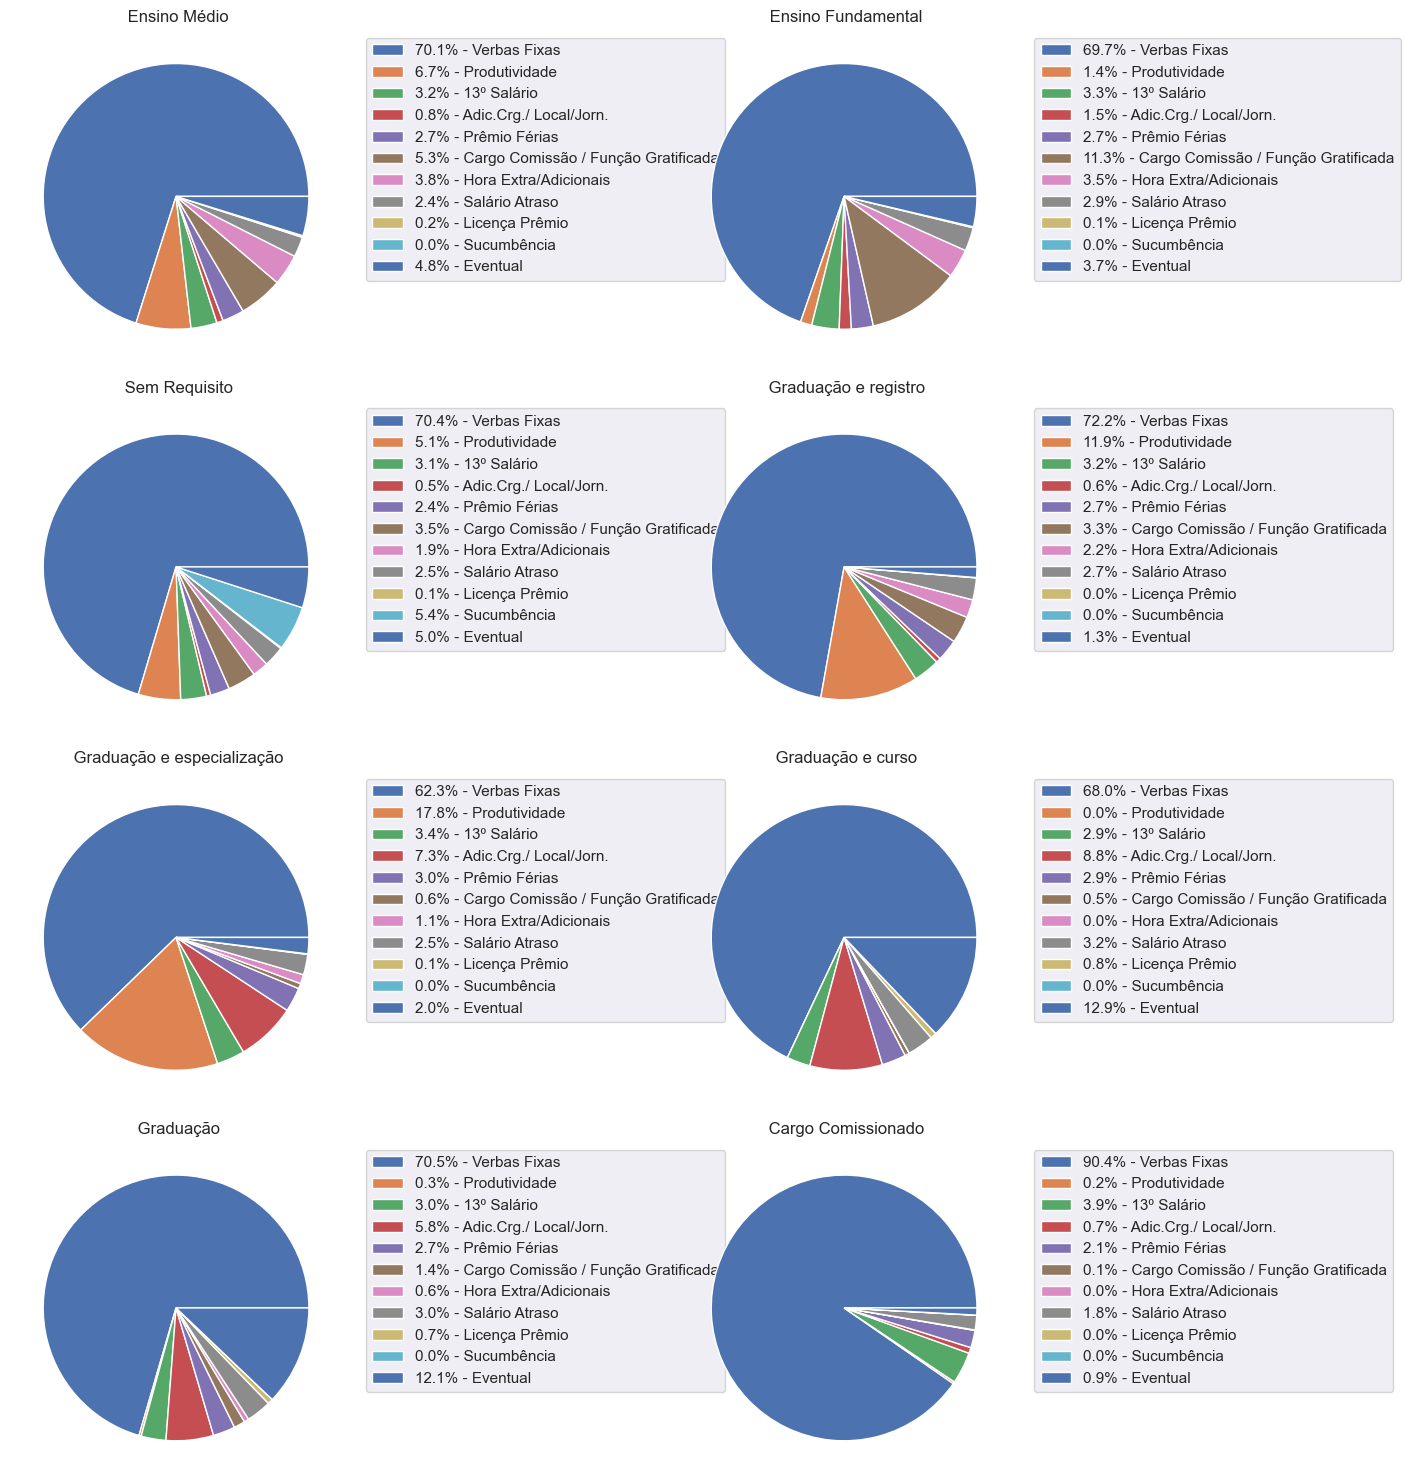

In [39]:
dfaux = df[df['Anomes'].between(*range_meses_analise) & (df['Experiência Requerida'].str.contains('Não é exigido experiência'))] # filtra o publico da analise
dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:]
grupos = dfaux['Requisitos agrupados'].unique()
verbas = ['Verbas Fixas', 'Produtividade', '13º Salário', 'Adic.Crg./ Local/Jorn.', 'Prêmio Férias', 'Cargo Comissão / Função Gratificada', 'Hora Extra/Adicionais', 'Salário Atraso', 'Licença Prêmio', 'Sucumbência', 'Eventual']

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,15))
axs = axs.flatten()

for i, grupos in enumerate(grupos):
    df_ano = dfaux[dfaux['Requisitos agrupados']==grupos][verbas]
    soma = df_ano.sum()
    soma_perc = soma/soma.sum() * 100
    
    # Criar legendas com porcentagens
    labels = [f"{soma_perc[j]:.1f}% - {verbas[j]}" for j, verba in enumerate(verbas)]

    axs[i].pie(soma_perc, labels=None, autopct=None)
    axs[i].legend(labels, bbox_to_anchor=(1.05, 1))
    axs[i].set_title(f'{grupos}')

plt.tight_layout()
plt.show()


## 4 - Requisitos de cargos que exigem experiencia prévia

### 4.1 Decil de Salário por requisito

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\3122724443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"


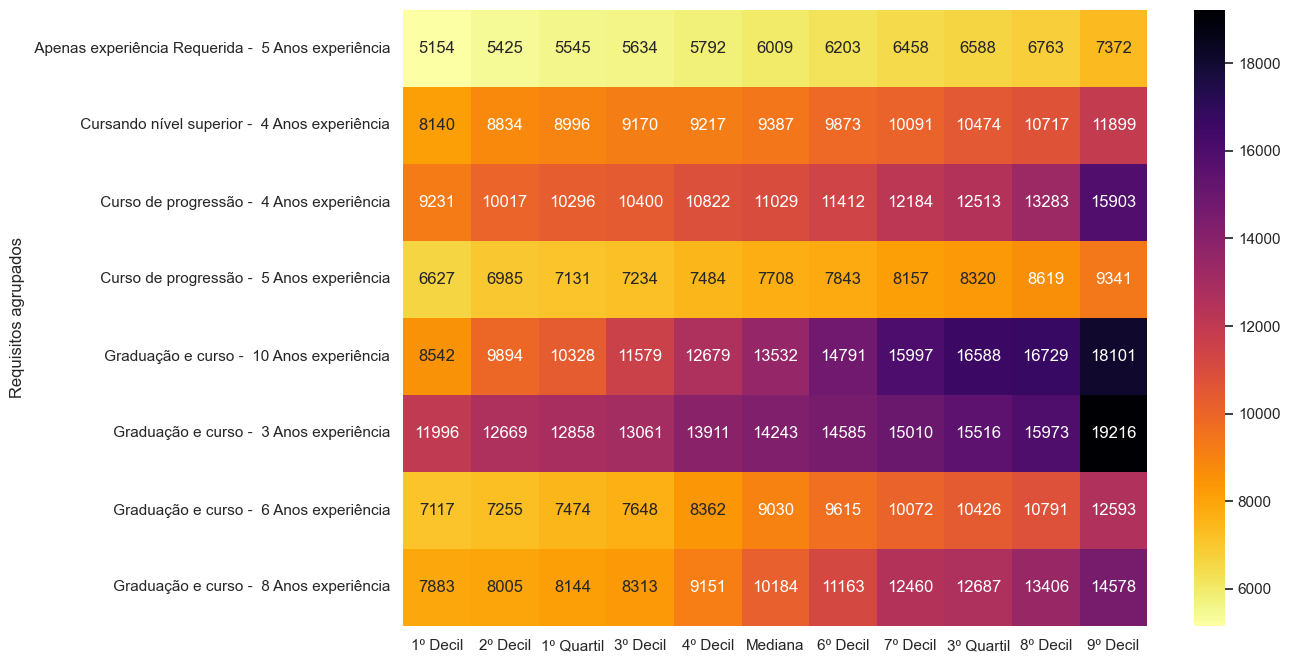

In [40]:
dfaux = df[(df['Anomes']== mes_para_filtrar_media_movel) & ~(df['Experiência Requerida'].str.contains('Não é exigido experiência'))]
dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"
decil_geral = (
    dfaux
    .groupby(['Requisitos agrupados']).agg(
    d1 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.1)),
    d2 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.2)),
    q1 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.25)),
    d3 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.3)),
    d4 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.4)),
    d5 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.5)),
    d6 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.6)),
    d7 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.7)),
    q3 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.75)),
    d8 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.8)),
    d9 = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.9)),
    )
)

# Renomeia os Decis para melhor interpretabilidade
decil_geral_rn = decil_geral.rename({
    'd1': '1º Decil',
    'd2': '2º Decil',
    'q1': '1º Quartil',
    'd3': '3º Decil',
    'd4': '4º Decil',
    'd5': 'Mediana',
    'd6': '6º Decil',
    'd7': '7º Decil',
    'q3': '3º Quartil',
    'd8': '8º Decil',
    'd9': '9º Decil',
}, axis=1) 

# carrega as definições padrões do Seaborn
sns.set()

# define o gráfico
ax = sns.heatmap(decil_geral_rn, annot=True, fmt=".0f", cmap='inferno_r')

# Imprime o Gráfico
plt.show()

### 4.2 Serie temporal verbas por requisitos

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\2419039158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"
C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\2419039158.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_mediana = mediana.pivot('Ano', 'Requisitos agrupados', 'mediana')


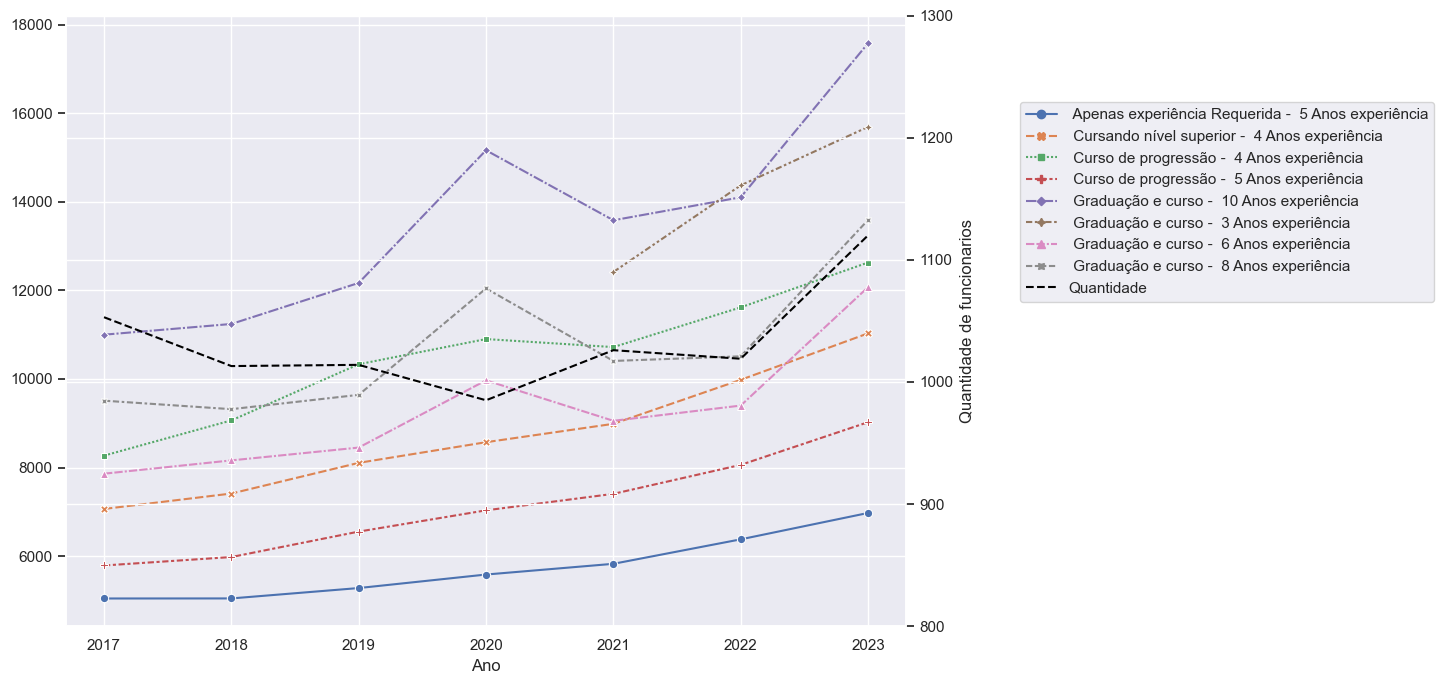

In [41]:
dfaux = df[(df['Ano']!=2016) & ~(df['Experiência Requerida'].str.contains('Não é exigido experiência'))]
dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"

mediana = dfaux.groupby(['Ano', 'Requisitos agrupados']).agg(
    mediana = ('Bruto recebido média 12 meses', lambda x: x.quantile(0.5)),
).reset_index() 

pivot_mediana = mediana.pivot('Ano', 'Requisitos agrupados', 'mediana')

sns.set()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.lineplot(pivot_mediana, markers=True, ax=ax)
ax.legend_.remove() # remove a legenda do interior do gráfico

# Cria eixo secundario com quantidade de pessoas
mediana_quantidade = dfaux.groupby(['Ano']).agg(
    quantidade = ('Matricula', 'nunique')
).reset_index() 

ax_aux = ax.twinx()
sns.lineplot(mediana_quantidade, x="Ano", y='quantidade', label='Quantidade', ax=ax_aux, color='black', linestyle="--")
ax_aux.set_ylim([800, 1300])
ax_aux.set_ylabel('Quantidade de funcionarios')
ax_aux.legend_.remove() # remove a legenda do interior do gráfico

# Cria apenas uma legenda
handles, labels = ax.get_legend_handles_labels()
handles_aux, labels_aux = ax_aux.get_legend_handles_labels()
handles = handles + handles_aux
labels = labels + labels_aux
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.45, 0.7))

plt.tight_layout()
plt.show()

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\2450434109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"


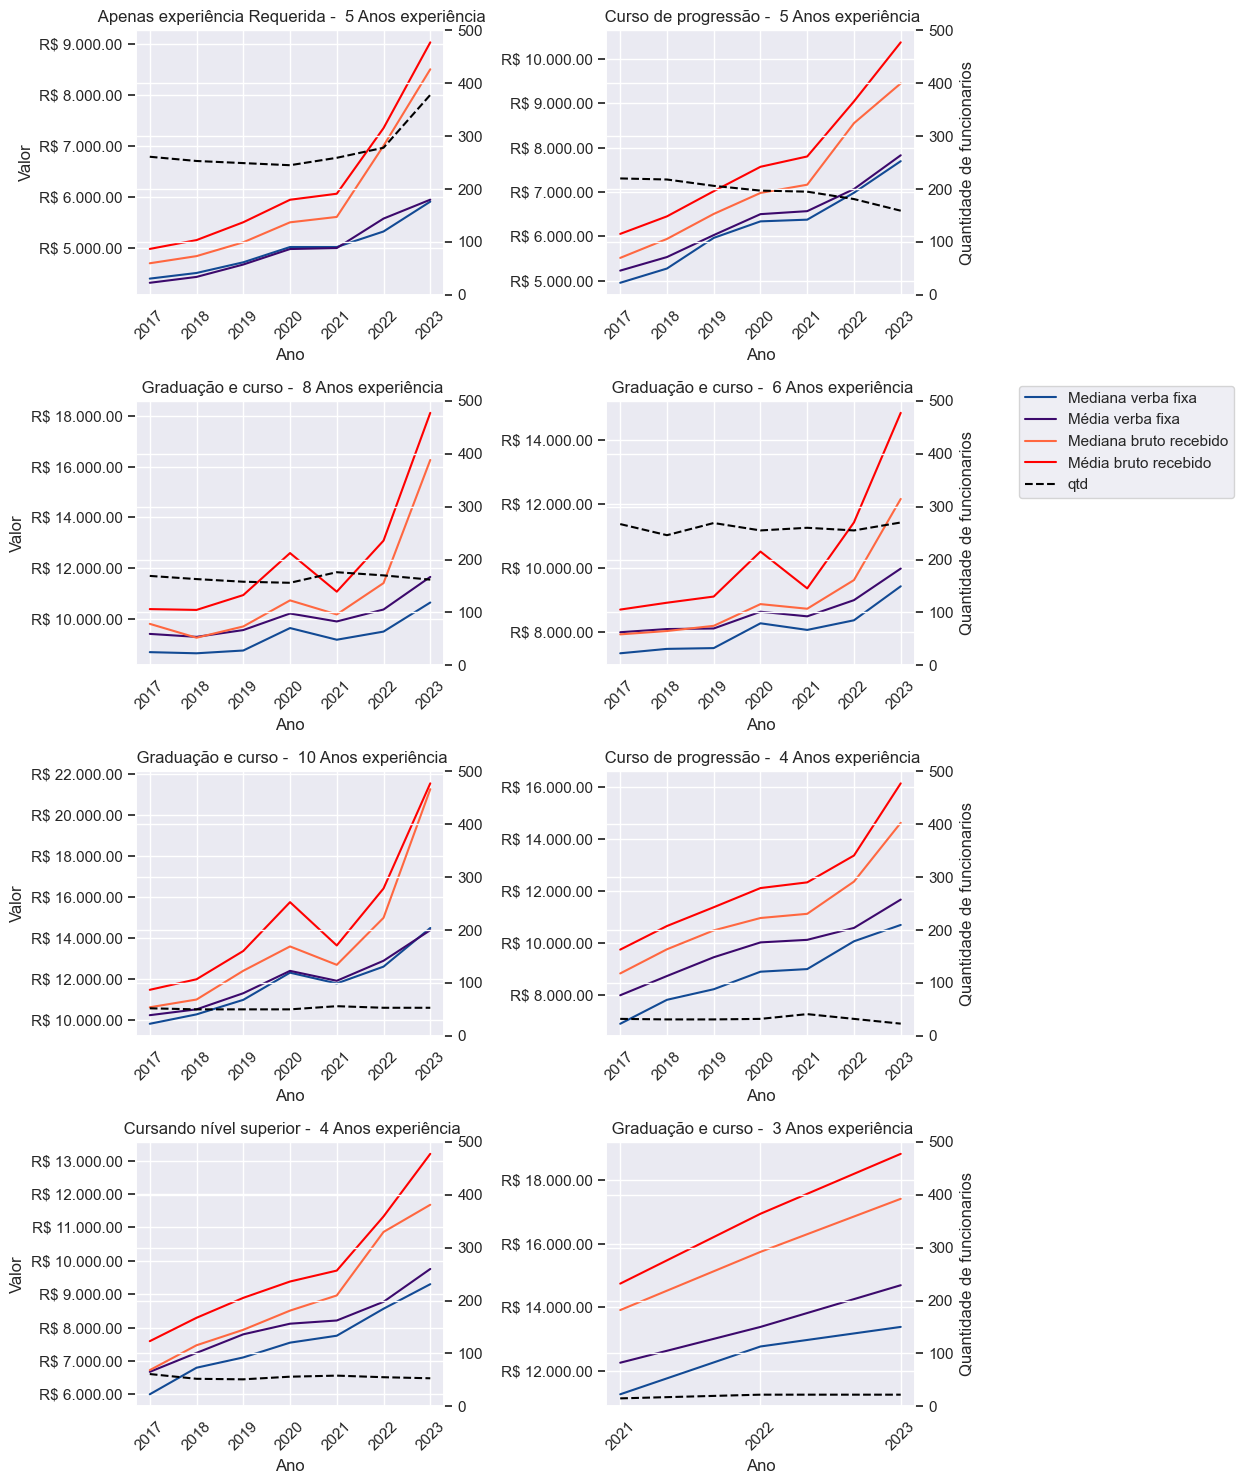

In [42]:
dfaux = df[(df['Ano']!=2016) & ~(df['Experiência Requerida'].str.contains('Não é exigido experiência'))] # filtra o publico da analise

dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"
dfaux_cargo_ano = dfaux.groupby(['Requisitos agrupados', 'Ano']).agg(
    mediana_fixa = ('Verbas Fixas', lambda x: x.quantile(0.5)),
    media_fixa = ('Verbas Fixas', 'mean'),
    mediana_bruto = ('Bruto recebido', lambda x: x.quantile(0.5)),
    media_bruto = ('Bruto recebido', 'mean'),
    qtd_pessoas = ('Matricula', 'nunique'),
).reset_index()

# Criando a figura com 2 subplots (ax1 e ax2)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
ax = ax.flatten()

cats = dfaux['Requisitos agrupados'].unique()

for i, cat in enumerate(cats):
    dfaux_1 = dfaux_cargo_ano[dfaux_cargo_ano['Requisitos agrupados'] == cat]
    sns.lineplot(data=dfaux_1, x="Ano", y='mediana_fixa', label='Mediana verba fixa', ax=ax[i], color='#124A94')
    sns.lineplot(data=dfaux_1, x="Ano", y='media_fixa', label='Média verba fixa', ax=ax[i], color='#3c096c')
    sns.lineplot(data=dfaux_1, x="Ano", y='mediana_bruto', label='Mediana bruto recebido', ax=ax[i], color='#FF6740')
    sns.lineplot(data=dfaux_1, x="Ano", y='media_bruto', label='Média bruto recebido', ax=ax[i], color='red')
    ax[i].set_title(cat)
    ax[i].yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.'))
    ax[i].set_ylabel('Valor' if i%2 == 0 else '')
    ax[i].tick_params(axis='x', labelrotation=45)
    ax[i].set_xticks(dfaux_1['Ano'].unique())
    ax[i].legend_.remove() # remove a legenda do interior do gráfico

    # Cria eixo secundario com quantidade de pessoas
    ax_aux = ax[i].twinx()
    sns.lineplot(dfaux_1, x="Ano", y='qtd_pessoas', label='qtd', ax=ax_aux, color='black', linestyle="--")
    ax_aux.set_ylim([0, 500])
    ax_aux.set_ylabel('Quantidade de funcionarios' if i%2 == 1 else '')
    ax_aux.legend_.remove() # remove a legenda do interior do gráfico


# Cria apenas uma legenda
handles, labels = ax[0].get_legend_handles_labels()
handles_aux, labels_aux = ax_aux.get_legend_handles_labels()
handles = handles + handles_aux
labels = labels + labels_aux
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.25, 0.7))

plt.tight_layout()
plt.show()

### 4.3 Boxplot

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\1975722478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"
C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\1975722478.py:16: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dfaux_2_grouped =

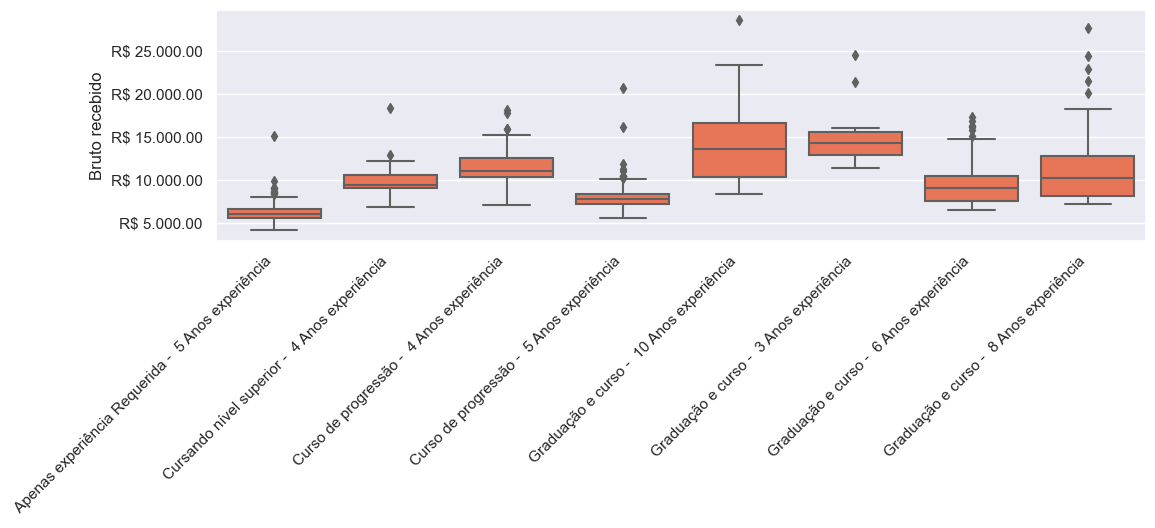

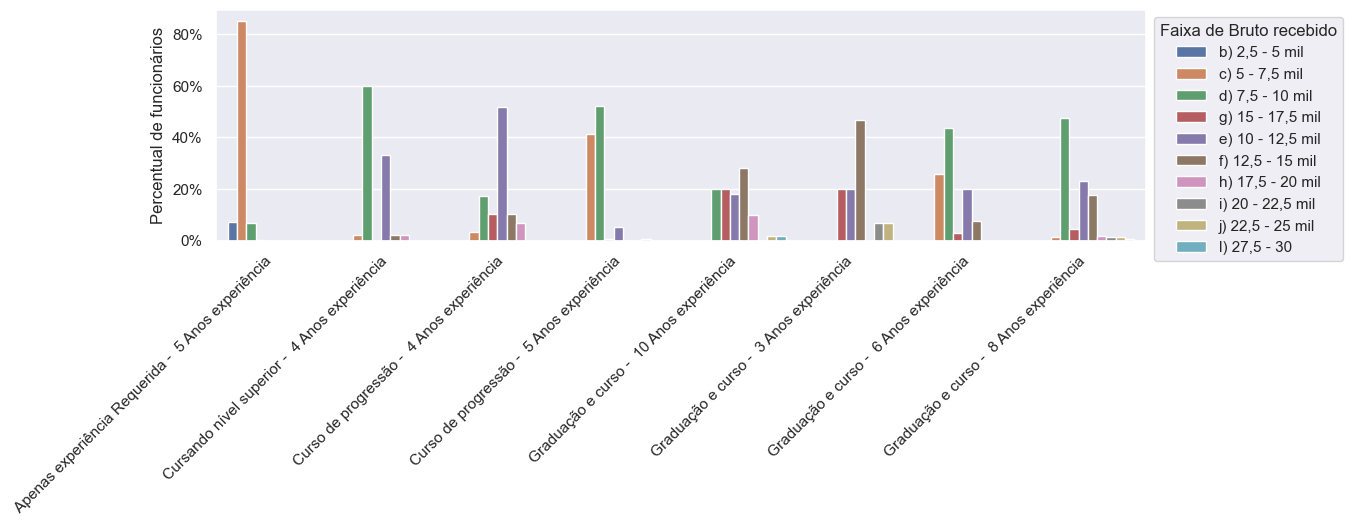

In [43]:
dfaux = df[(df['Anomes']==mes_para_filtrar_media_movel) & ~(df['Experiência Requerida'].str.contains('Não é exigido experiência'))]
dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"
dfaux = dfaux.sort_values('Requisitos agrupados')

# Cria o boxplot do Bruto recebido
fig, ax1 = plt.subplots(figsize=(12,3))
sns.boxplot(data=dfaux, x="Requisitos agrupados", y='Bruto recebido média 12 meses', ax=ax1, color='#FF6740')
# ax1.set_title('Bruto recebido por categoria de Requisitos agrupados')
ax1.set_xlabel('')
ax1.set_ylabel('Bruto recebido')
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_xticklabels(ax1.get_xticklabels(), ha="right")
ax1.yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.'))

# Cria o gráfico de barras da quantidade de servidores por faixa de Bruto recebido
dfaux_2_grouped = dfaux.groupby(['Requisitos agrupados', 'Faixa bruto']).agg({'Matricula': 'nunique'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
fig, ax2 = plt.subplots(figsize=(12,3))
sns.barplot(data=dfaux_2_grouped, x="Requisitos agrupados", y='Matricula', hue='Faixa bruto', ax=ax2)
# ax2.set_title('Percentual de funcionários por faixa de Bruto recebido')
ax2.set_xlabel('')
ax2.set_ylabel('Percentual de funcionários')
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), ha="right")
ax2.yaxis.set_major_formatter(lambda x, p: f'{int(x):,.0f}%'.replace(',', '.'))
ax2.legend(title='Faixa de Bruto recebido', bbox_to_anchor=(1, 1))

### 4.4 Valores por nível requerido

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\517459440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"


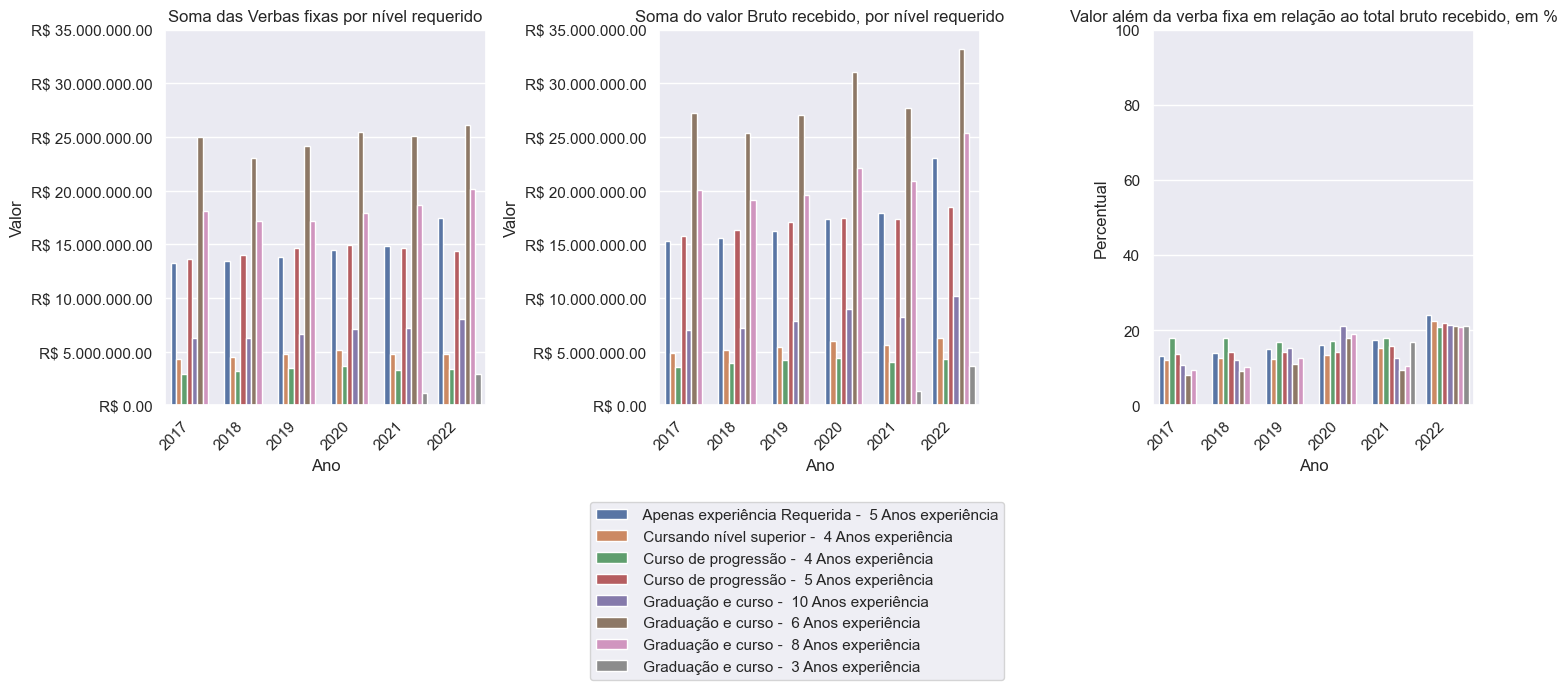

In [44]:
# Ordena os dados por cargo e ano
dfaux = df[(df['Ano']!= 2016) & (df['Ano']!= 2023) &  ~(df['Experiência Requerida'].str.contains('Não é exigido experiência'))]
dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"
dfaux_cargo_ano = dfaux.groupby(['Ano','Requisitos agrupados']).agg(
    verba_fixa = ('Verbas Fixas', 'sum'),
    bruto_recebido = ('Bruto recebido', 'sum'),
    qtd_pessoas = ('Matricula', 'nunique'),
).reset_index()


dfaux_cargo_ano['percentual'] = 100 * (dfaux_cargo_ano['bruto_recebido'] - dfaux_cargo_ano['verba_fixa']) / dfaux_cargo_ano['bruto_recebido']


sns.set()
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))

sns.barplot(data = dfaux_cargo_ano, x='Ano', y='verba_fixa', hue="Requisitos agrupados", ax=ax[0])
ax[0].set_title("Soma das Verbas fixas por nível requerido")
ax[0].yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.')) # formatação dos valores do eixo y
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_ylabel('Valor')
# ajuste de alinhamento dos rótulos das barras
labels = ax[0].get_xticklabels() # pega os rótulos do eixo x
ax[0].set_xticklabels(labels, ha="right") # ajusta o alinhamento dos rótulos para a direita
ax[0].set_ylim([0, 3.5e7])

sns.barplot(data = dfaux_cargo_ano, x='Ano', y='bruto_recebido', hue="Requisitos agrupados", ax=ax[1])
ax[1].set_title("Soma do valor Bruto recebido, por nível requerido")
ax[1].yaxis.set_major_formatter(lambda x, p: f'R$ {x:,.2f}'.replace(',', '.')) # formatação dos valores do eixo y
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_ylabel('Valor')
# ajuste de alinhamento dos rótulos das barras
labels = ax[1].get_xticklabels() # pega os rótulos do eixo x
ax[1].set_xticklabels(labels, ha="right") # ajusta o alinhamento dos rótulos para a direita
ax[1].set_ylim([0, 3.5e7])

sns.barplot(data = dfaux_cargo_ano, x='Ano', y='percentual', hue="Requisitos agrupados", ax=ax[2])
ax[2].set_title("Valor além da verba fixa em relação ao total bruto recebido, em %")
ax[2].yaxis.set_major_formatter(lambda x, p: f'{x:,.0f}'.replace(',', '.')) # formatação dos valores do eixo y
ax[2].tick_params(axis='x', labelrotation=45)
ax[2].set_ylabel('Percentual')
ax[2].set_ylim([0,100])
axs[2].yaxis.set_major_formatter(lambda x, p: f'{x:,.0f}%'.replace(',', '.')) # formatação dos valores do eixo y
# ajuste de alinhamento dos rótulos das barras
labels = ax[2].get_xticklabels() # pega os rótulos do eixo x
ax[2].set_xticklabels(labels, ha="right") # ajusta o alinhamento dos rótulos para a direita

# Remover as legendas dos gráficos
ax[0].legend_.remove()
ax[1].legend_.remove()
ax[2].legend_.remove()

# Cria a legenda apenas para o primeiro gráfico
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.68, -0.2))

plt.tight_layout() # Previne sobreposição
plt.show()

### 4.5 Composição Salarial por requisito

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18408\3163170206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"


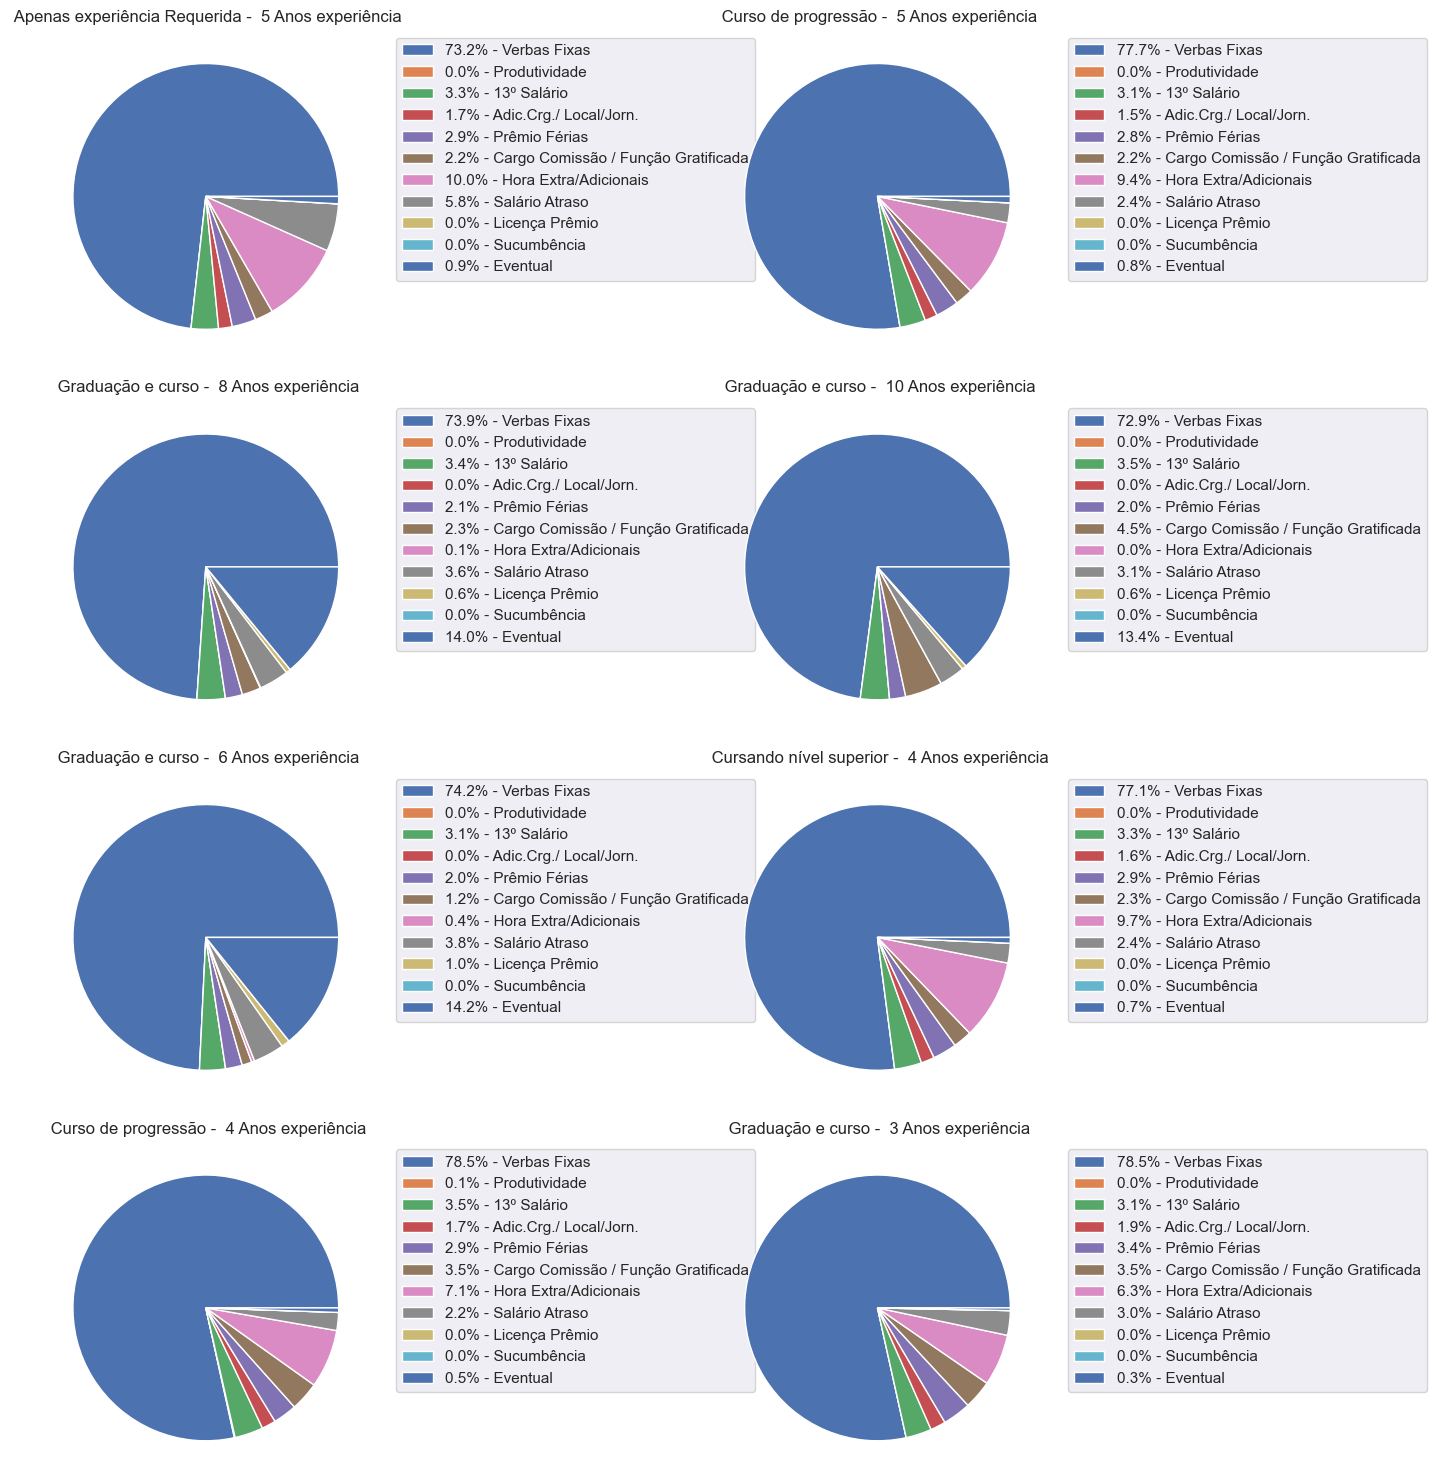

In [45]:
dfaux = df[df['Anomes'].between(*range_meses_analise) & ~(df['Experiência Requerida'].str.contains('Não é exigido experiência'))] # filtra o publico da analise
dfaux['Requisitos agrupados'] = dfaux['Requisitos agrupados'].astype(str).str[2:] + " - " + dfaux['Experiência Requerida'].astype(str).str[2:] + " experiência"
grupos = dfaux['Requisitos agrupados'].unique()
verbas = ['Verbas Fixas', 'Produtividade', '13º Salário', 'Adic.Crg./ Local/Jorn.', 'Prêmio Férias', 'Cargo Comissão / Função Gratificada', 'Hora Extra/Adicionais', 'Salário Atraso', 'Licença Prêmio', 'Sucumbência', 'Eventual']


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,15))
axs = axs.flatten()

for i, grupos in enumerate(grupos):
    df_ano = dfaux[dfaux['Requisitos agrupados']==grupos][verbas]
    soma = df_ano.sum()
    soma_perc = soma/soma.sum() * 100
    
    # Criar legendas com porcentagens
    labels = [f"{soma_perc[j]:.1f}% - {verbas[j]}" for j, verba in enumerate(verbas)]

    axs[i].pie(soma_perc, labels=None, autopct=None)
    axs[i].legend(labels, bbox_to_anchor=(1.05, 1))
    axs[i].set_title(f'{grupos}')


plt.tight_layout()
plt.show()
